In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 13.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import math

##LSTM
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from datetime import datetime

#import optuna

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile


In [2]:
df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_vwc_.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_stemp_.npy', allow_pickle=True)

df_vwc7 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_vwc.npy', allow_pickle=True)
df_stemp7 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_stemp.npy', allow_pickle=True)

df_vwc11 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_vwc.npy', allow_pickle=True)
df_stemp11 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_stemp.npy', allow_pickle=True)

df_T = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_T.npy', allow_pickle=True)
df_RH = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_RH.npy', allow_pickle=True)
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_Rain.npy', allow_pickle=True)
df_WS = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WS.npy', allow_pickle=True)
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_S.npy', allow_pickle=True)




In [3]:
####################################################################################################
def nmse(y_true, y_pred):
    """
    Calculate the normalized mean squared error (NMSE) between y_true and y_pred.
    """
    return np.mean(np.square(y_pred - y_true)) / np.var(y_true)
# Register the custom metric function with Keras
with custom_object_scope({'nmse': nmse}):
    get_custom_objects().update({'nmse': nmse})
####################################################################################################
def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    """
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Register the custom metric function with Keras
with custom_object_scope({'smape': smape}):
    get_custom_objects().update({'smape': smape})
####################################################################################################
def smase(y_true, y_pred, y_naive):
    """
    Calculate the Symmetric Mean Absolute Scaled Error (sMASE) between y_true and y_pred, relative
    to a symmetric naive forecast y_naive.
    """
    # Calculate the symmetric naive forecast
    y_sym_naive = (y_naive.shift(1) + y_naive.shift(-1)) / 2.0

    # Calculate the MAPE of the forecast relative to the symmetric naive forecast
    mape_forecast = np.mean(np.abs(y_pred - y_sym_naive) / np.abs(y_true - y_sym_naive))

    # Calculate the MAPE of the historical data relative to the same symmetric naive forecast
    mape_historical = np.mean(np.abs(y_true - y_sym_naive.shift(1)) / np.abs(y_true - y_sym_naive))

    return mape_forecast / mape_historical

# Register the custom metric function with Keras
with custom_object_scope({'smase': smase}):
    get_custom_objects().update({'smase': smase})
####################################################################################################
def nse(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) between y_true and y_pred.
    """
    mse = mean_squared_error(y_true, y_pred)
    rss = mse * len(y_true)
    tss = mean_absolute_error(y_true, np.mean(y_true)) ** 2 * len(y_true)
    return 1 - (rss / tss)

with custom_object_scope({'nse': nse}):
    get_custom_objects().update({'nse': nse})
# #####################################################################################################
# def r2_keras(y_true, y_pred):
#     SS_res =  K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

keras.backend.set_image_data_format('channels_last')
import tensorflow as tf

def r2_keras(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + keras.backend.epsilon())
    return r2

# Register the custom metric function with Keras
with custom_object_scope({'r2_keras': r2_keras}):
    get_custom_objects().update({'r2_keras': r2_keras})


def rmse_(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def compute_scores(actual, predicted):
    rmse_score = rmse_(actual, predicted)
    nmse_score = nmse(actual, predicted)
    smape_score = smape(actual, predicted)
    nse_score = nse(actual, predicted)
    r2_score = r2_keras(actual, predicted)
    return rmse_score, nmse_score, smape_score, nse_score, r2_score

In [4]:
##Encoder/Decoder LSTM with Multivariate Input

#Splitting datasets into train/test set
def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57]
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

# #train the model LSTM-ED

def build_model(train, config, verbose):
  # Unpack config
  n_input, n_nodes, n_epochs, n_batch = config
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # Parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

  #define model

  # define model input
  inputs = Input(shape=(n_timesteps, n_features))

  # encoder layers
  encoder = CuDNNLSTM(n_nodes)(inputs)
  encoder = RepeatVector(n_outputs)(encoder)

  # decoder layers
  decoder = CuDNNLSTM(n_nodes, return_sequences=True)(encoder)
  decoder = TimeDistributed(Dense(n_nodes/2))(decoder)
  decoder = TimeDistributed(Dense(1))(decoder)

  # define model
  model = Model(inputs=inputs, outputs=decoder)

  model.compile(loss='mae', optimizer='adam',  metrics= ['MeanAbsoluteError', 'MeanSquaredError', 'mean_absolute_percentage_error', 'r2_keras', 'smape', 'nse'])

  # fit network
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose= verbose)
  plt.plot(model.history.history['loss'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['loss'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_error'])
  plt.plot(model.history.history['mean_squared_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_error', 'mean_squared_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_percentage_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_percentage_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['r2_keras'])
  #plt.plot(model.history.history[])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['r2_score'], loc='upper right')
  plt.show()
  return model

#forecast

def forecast(model, history, config):
  # unpack config
  n_input, _, _, _ = config
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

def forecast_test(model, history, n_input):
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

#evaluate a single model

def evaluate_model(train, test, cfg, verbose):
  #fit model
  model= build_model(train, cfg, verbose)
  #test = X_scaler.transform(test)
  # history is a list of n_input data
  history = [x for x in train]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast(model, history, cfg)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model

def evaluate_test(train, test, filename):
  model = load_model(filename)
  history = [x for x in test]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast_test(model, history, n_input)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
    print(np.array(history).shape)
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions


IMF 0

In [5]:
# define the objective function
def objective(trial):

    # specify the hyperparameters to optimize
    n_input = trial.suggest_int('n_input', 24, 100)
    n_nodes = trial.suggest_int('n_nodes', 32, 256)
    n_epochs = trial.suggest_int('n_epochs', 10, 100)
    n_batch = trial.suggest_int('n_batch', 16, 128)

    # split the data into training and testing sets
    train, test = split_dataset(df_s.values)
    #train = df_s.values

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[i:i+fold_size] for i in range(0, len(train), fold_size)]

    # build the model using the hyperparameters
    model = build_model(train, (n_input, n_nodes, n_epochs, n_batch), verbose=False)


    # train and evaluate the model using walk-forward validation
    val_losses = []
    for i in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:i] + folds[i+1:]), n_input)
        val_x, val_y = to_supervised(folds[i], n_input)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))

        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data=(val_x, val_y), verbose=False, callbacks=[es])

        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

        # metrics on validation set for this fold
        #al_mae = history.history['mean_absolute_error'][-1]
        #val_mse = history.history['mean_squared_error'][-1]

    # return the mean validation loss across all folds
    return np.mean(val_losses)

In [29]:
pd.DataFrame(df_vwc)

,0,1,2,3,4,5,6,7,8,9,...,24181,24182,24183,24184,24185,24186,24187,24188,24189,24190
0,-0.000354,0.030651,0.382883,-0.401099,0.067952,0.101060,-0.068248,0.083636,-0.099464,-0.203373,...,0.165050,-0.297925,0.282220,-0.253225,0.147636,-0.298923,0.299910,-0.202946,0.195767,-0.356949
1,0.029564,-0.047585,0.009359,0.110083,0.136726,0.004188,-0.084457,-0.035883,0.003350,-0.043374,...,0.047825,0.010999,0.095975,0.144268,-0.041017,-0.156346,-0.111588,0.036439,0.092825,-0.052503
2,0.095448,0.079525,0.058039,0.046841,0.044029,0.040881,0.025944,-0.006245,-0.054150,-0.087490,...,-0.060975,-0.031193,0.032657,0.104031,0.150236,0.154046,0.116541,0.049434,-0.023567,-0.086341
3,0.099676,0.098648,0.091234,0.077780,0.058232,0.033180,0.006394,-0.017903,-0.036130,-0.045513,...,-0.040159,-0.018108,0.000587,0.014773,0.022988,0.024590,0.020127,0.010395,-0.004827,-0.024478
4,0.100152,0.100042,0.097576,0.092487,0.084945,0.075233,0.063637,0.050463,0.036038,0.020788,...,-0.000228,-0.006102,-0.012181,-0.018316,-0.024355,-0.030074,-0.035102,-0.039228,-0.042513,-0.045109
5,0.097977,0.099101,0.098714,0.096843,0.093578,0.089041,0.083362,0.076673,0.069136,0.060924,...,0.001609,0.003380,0.005354,0.007524,0.009866,0.012346,0.014901,0.017463,0.019985,0.022448
6,0.996514,0.997740,0.998691,0.999340,0.999657,0.999619,0.999209,0.998431,0.997294,0.995803,...,0.000629,0.001188,0.001728,0.002233,0.002691,0.003090,0.003423,0.003683,0.003870,0.003986
7,-0.561494,-0.565664,-0.569981,-0.574443,-0.579050,-0.583804,-0.588704,-0.593754,-0.598958,-0.604320,...,0.209876,0.209495,0.209085,0.208645,0.208176,0.207679,0.207153,0.206599,0.206016,0.205403
8,10.878595,10.878515,10.878665,10.879050,10.879670,10.880530,10.881631,10.882978,10.884572,10.886417,...,6.537010,6.537641,6.538224,6.538760,6.539249,6.539691,6.540086,6.540435,6.540736,6.540992


**S 2**


IMF:  0
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
(5775, 130, 7) (5775, 144)


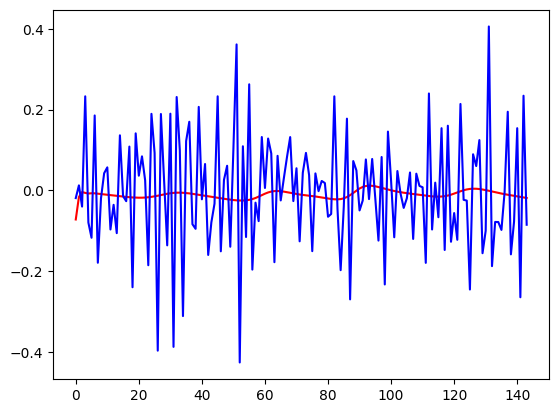

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
(5883, 22, 7) (5883, 144)


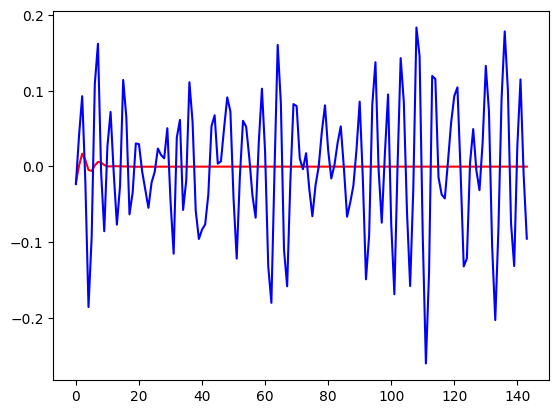

IMF:  2
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
(5784, 121, 7) (5784, 144)


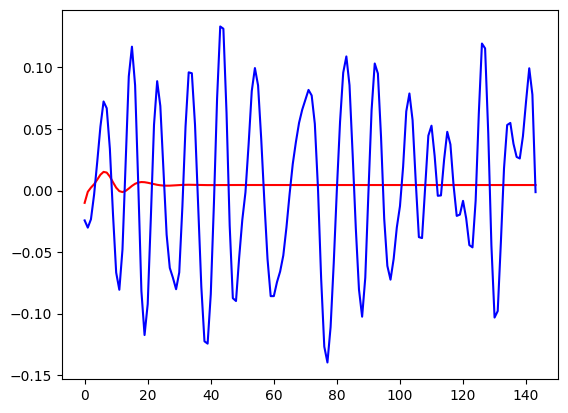

IMF:  3
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
(5816, 89, 7) (5816, 144)


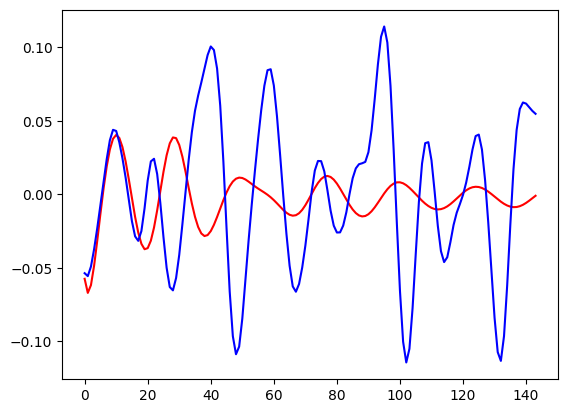

IMF:  4
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
(5815, 90, 7) (5815, 144)


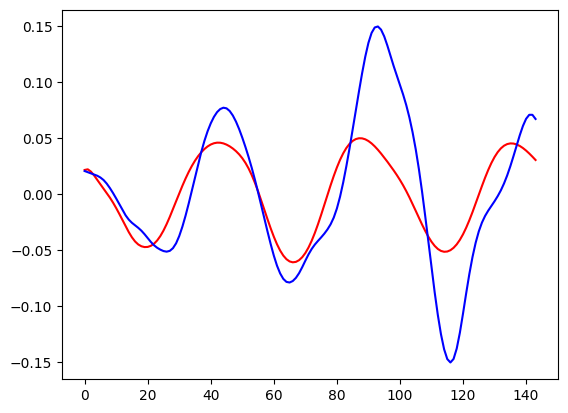

IMF:  5
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
(5836, 69, 7) (5836, 144)


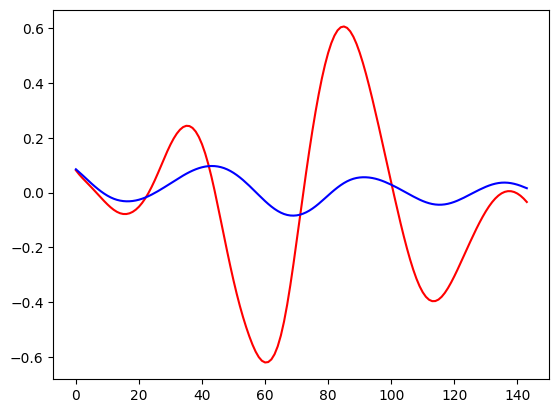

IMF:  6
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
(5888, 17, 7) (5888, 144)


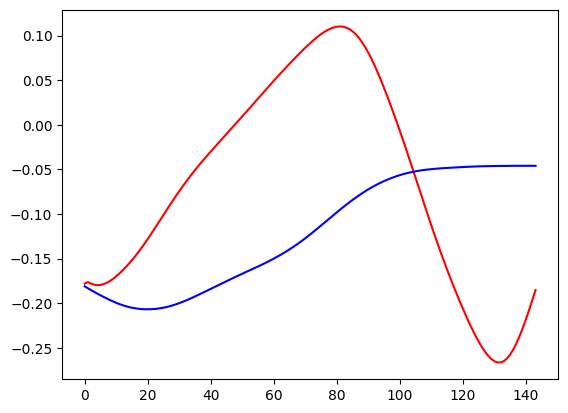

IMF:  7
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
(5850, 55, 7) (5850, 144)


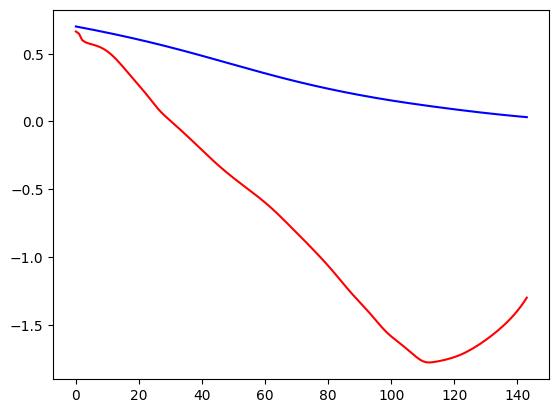

IMF:  8
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
(5821, 84, 7) (5821, 144)


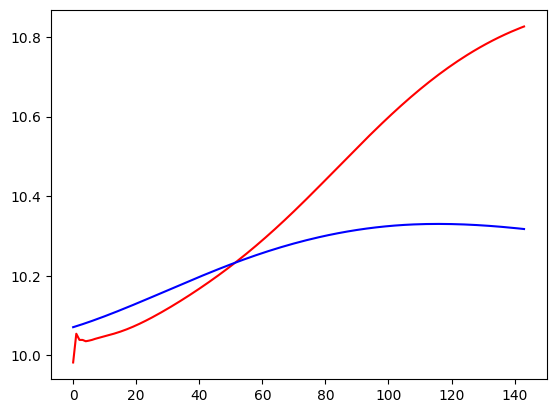

In [6]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

list_ = [df_vwc, df_Rain, df_stemp, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
IMFs = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs)):
  for i in list_:
    IMFs[k].append(i[k])

FPeemd2 = []
FP_teemd2 = []

FPaeemd2 = []
FP_taeemd2 = []

for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/'
  filename = f"{base_filename}{'S2_best_model_IMF_VWC'}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S2_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S2_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df
  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)
  print(test_X.shape, test_y.shape)
  v = 0
  y_h = loaded_model.evaluate(test_X[v].reshape(1,n_input,7), test_y[v].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPeemd2.append(y_hat[v])
  FP_teemd2.append(test_y[v])

  FPaeemd2.append(p[0])
  FP_taeemd2.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

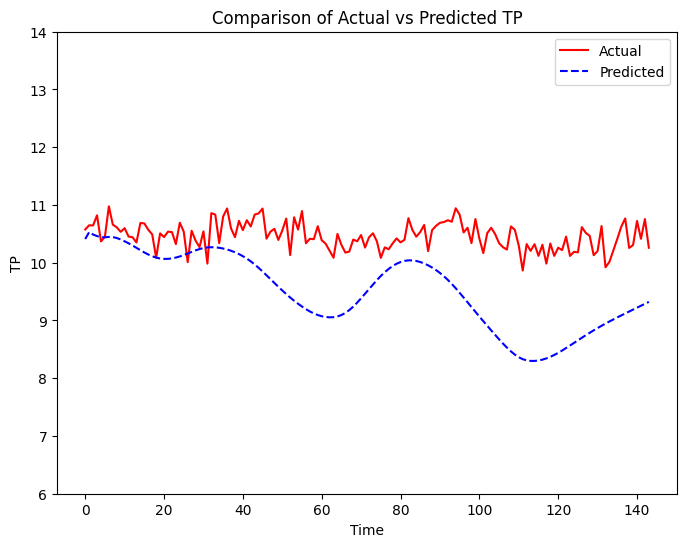

In [7]:
TP = sum(FPaeemd2[i] for i in range(9))
TP_t = sum(FP_taeemd2[i] for i in range(9))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Set y-axis limits
ax.set_ylim(6, 14)

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [8]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 0.95977145 mse 1.2594838 rmse 1.1222672 nmse 22.891724 smape 9.813695400953293 mape 0.09189811 r2 tf.Tensor(-21.891727, shape=(), dtype=float32)
mae 1.1233318 mse 2.284585 rmse 1.5114844 nmse 1.0356389 smape 13.952606916427612 mape 0.16011634 r2 tf.Tensor(-0.03563881, shape=(), dtype=float32)


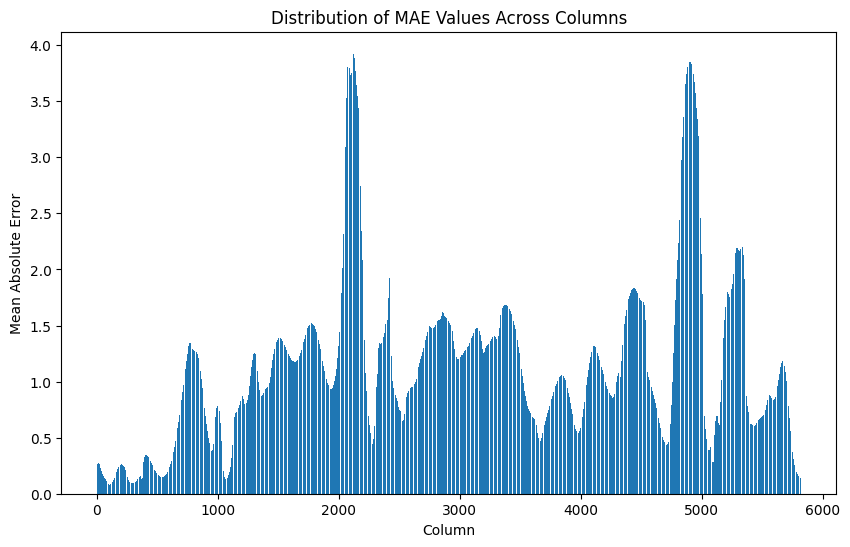

In [9]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [12]:
np.std(mae_scores)
np.mean(mae_scores)

1.1233319

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 17.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


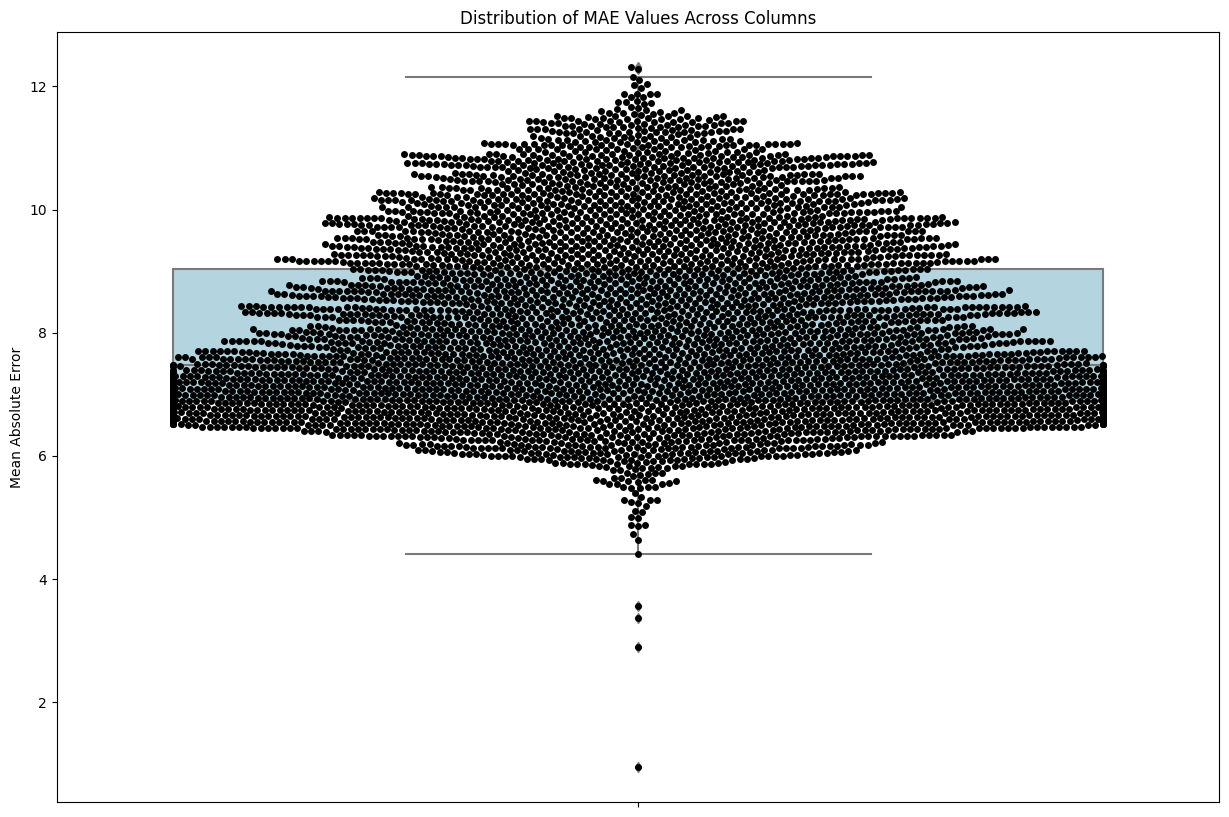

In [41]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.boxplot(y='Mean Absolute Error', data=mae_df, color='lightblue') # Boxplot
sns.swarmplot(y='Mean Absolute Error', data=mae_df, color='black') # Points
plt.title('Distribution of MAE Values Across Columns')
plt.show()




In [ ]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[6.347448825836182,
 6.347448825836182,
 46.66423797607422,
 30.629924774169922,
 -8386.66796875]

**S 7**

IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


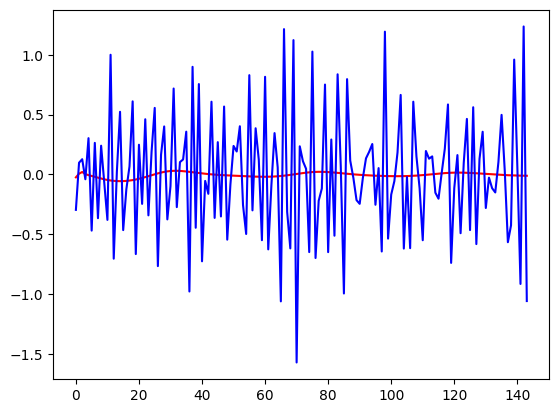

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


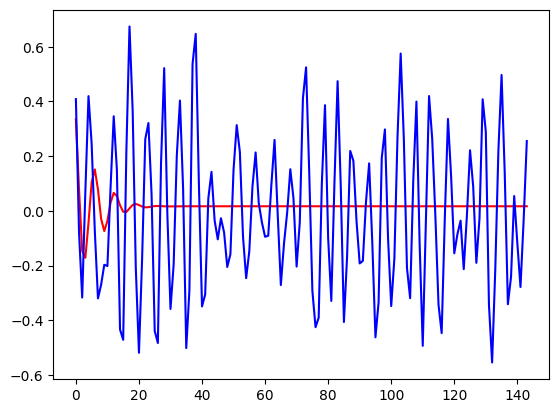

IMF:  2
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


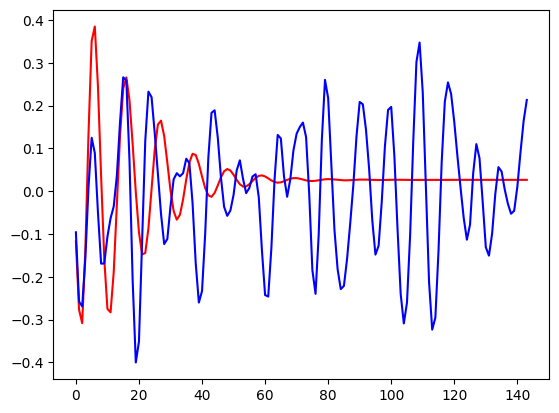

IMF:  3
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


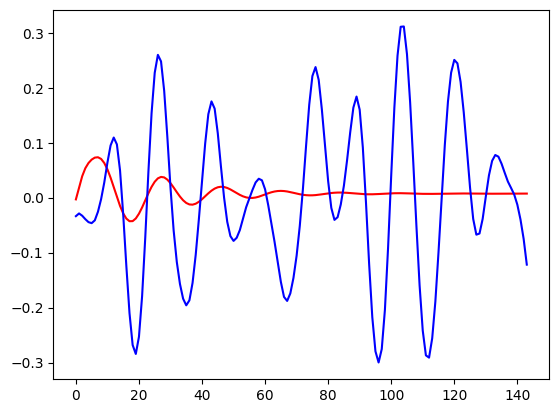

IMF:  4
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


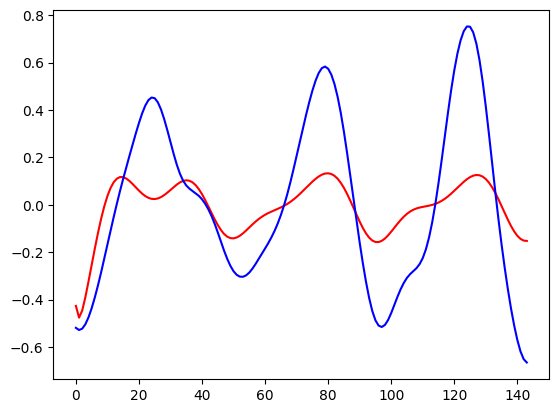

IMF:  5
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


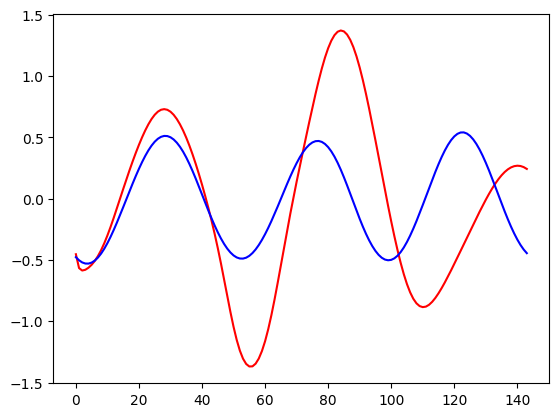

IMF:  6
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 14.1 µs


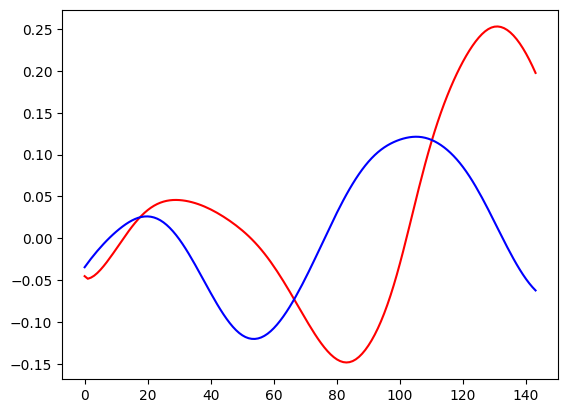

IMF:  7
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


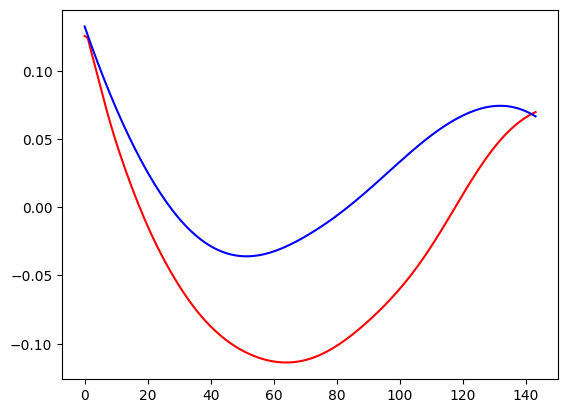

IMF:  8
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


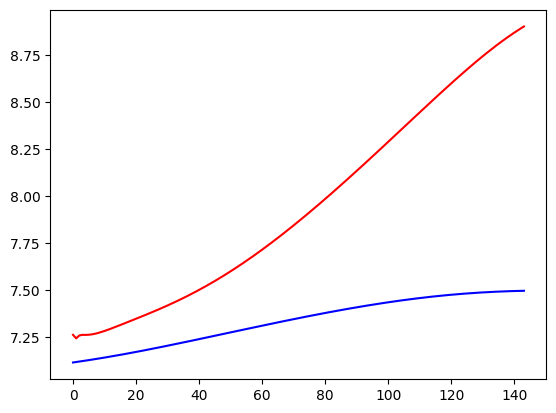

In [13]:


#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

list_ = [df_vwc7, df_Rain, df_stemp7, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
IMFs7 = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs7)):
  for i in list_:
    IMFs7[k].append(i[k])

FPeemd7 = []
FP_teemd7 = []

FPaeemd7 = []
FP_taeemd7 = []

for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S7_best_model_IMF_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(IMFs7[m]).T
  data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S7_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S7_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df


  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)
  v = -1
  y_h = loaded_model.evaluate(test_X[v].reshape(1,n_input,7), test_y[v].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPeemd7.append(y_hat[v])
  FP_teemd7.append(test_y[v])

  FPaeemd7.append(p[0])
  FP_taeemd7.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

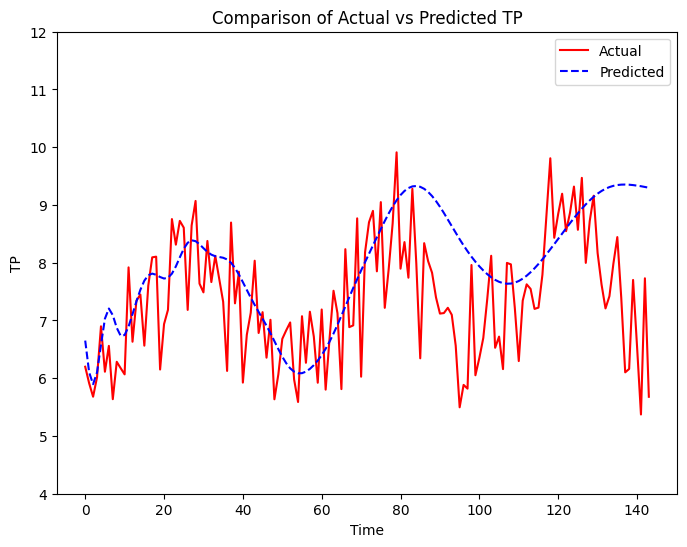

In [14]:
TP = sum(FPaeemd7[i] for i in range(9))
TP_t = sum(FP_taeemd7[i] for i in range(9))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Set y-axis limits
ax.set_ylim(4, 12)

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [15]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 0.90986717 mse 1.4238716 rmse 1.1932609 nmse 1.3085183 smape 11.99134960770607 mape 0.13257918 r2 tf.Tensor(-0.3085183, shape=(), dtype=float32)
mae 0.4470717 mse 0.36908862 rmse 0.60752666 nmse 0.79553896 smape 5.5740393698215485 mape 0.058230042 r2 tf.Tensor(0.20446074, shape=(), dtype=float32)


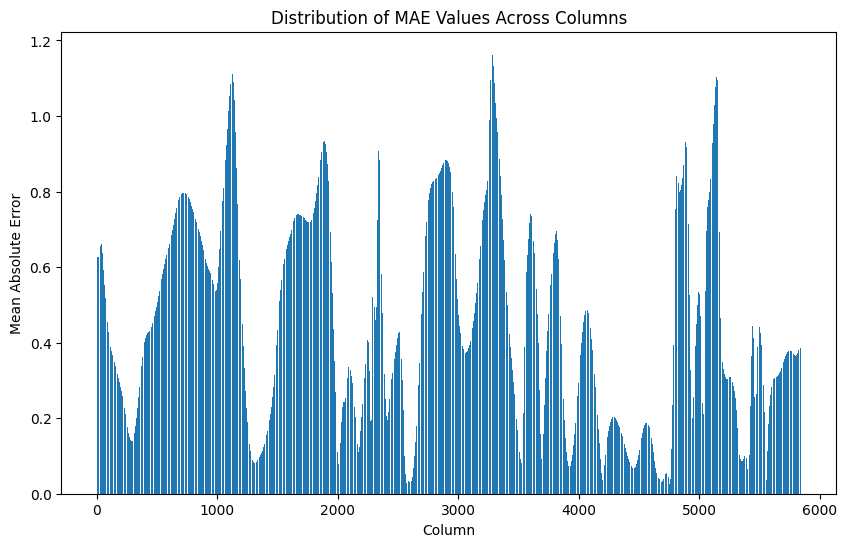

In [16]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [19]:
print(np.std(mae_scores), np.mean(mae_scores))

0.2765728 0.44707173


In [18]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[0.44707170128822327,
 0.44707170128822327,
 0.36908861994743347,
 5.82300329208374,
 -198.24159240722656]

**S 11**

IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


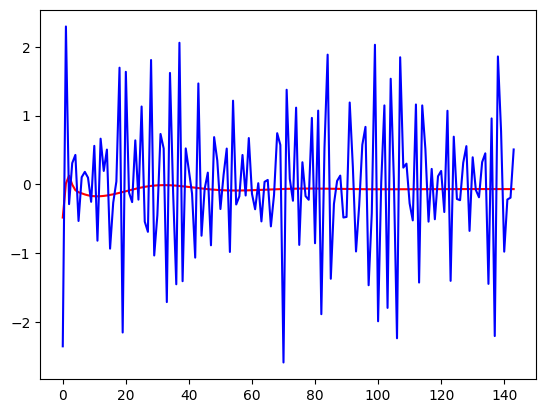

IMF:  1
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


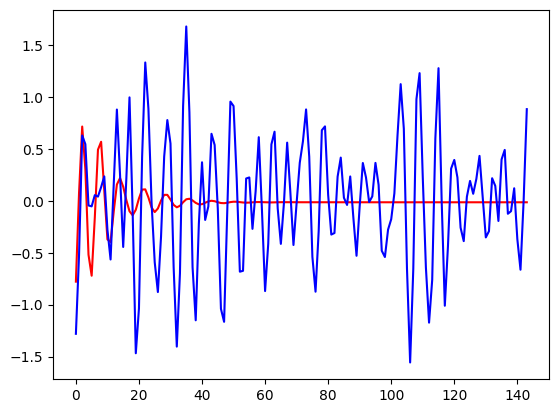

IMF:  2
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


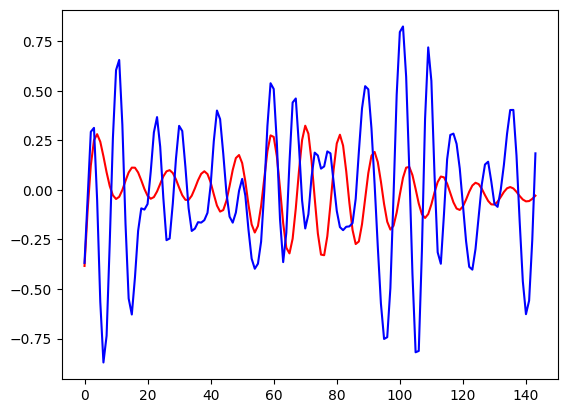

IMF:  3
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


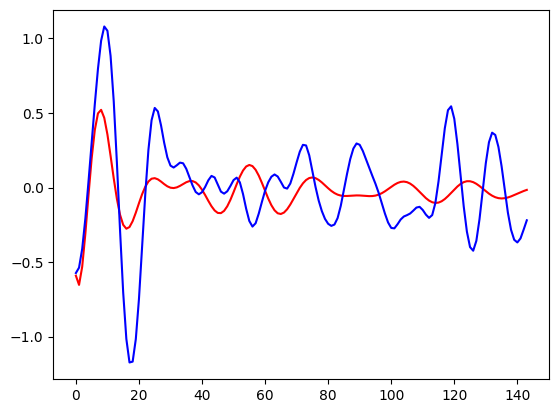

IMF:  4
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


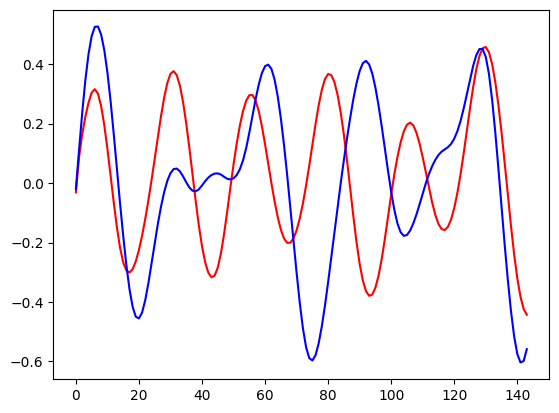

IMF:  5
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


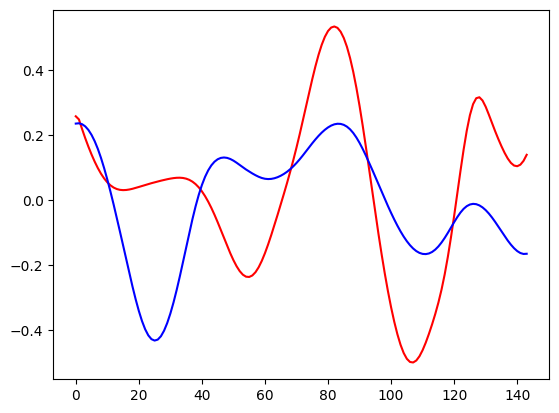

IMF:  6
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.72 µs


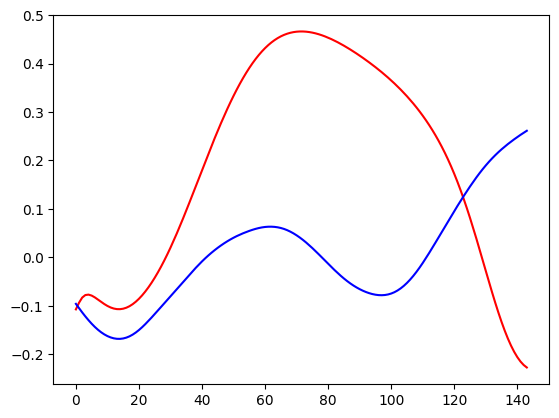

IMF:  7
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


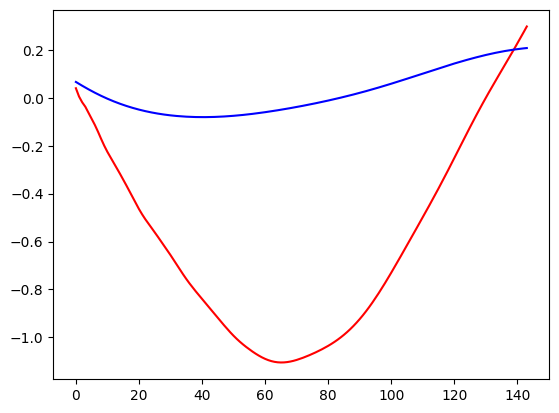

IMF:  8
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


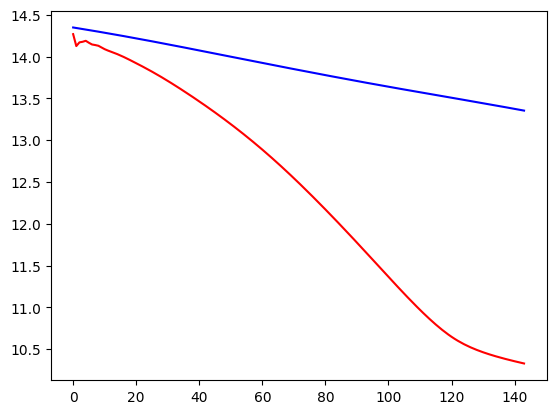

In [46]:


#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

list_ = [df_vwc11, df_Rain, df_stemp11, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
IMFs = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs)):
  for i in list_:
    IMFs[k].append(i[k])

FPeemd11 = []
FPaeemd11 = []
FP_teemd11 = []
FP_taeemd11 =[]
for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S11_best_model_IMF_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S11_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S11_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)
  v = 0
  y_h = loaded_model.evaluate(test_X[v].reshape(1,n_input,7), test_y[v].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPeemd11.append(y_hat[v])
  FP_teemd11.append(test_y[v])

  FPaeemd11.append(p[0])
  FP_taeemd11.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

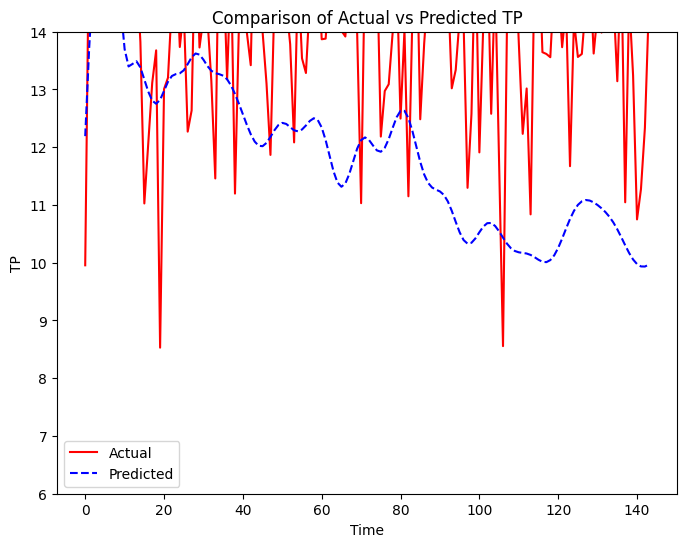

In [47]:
TP = sum(FPaeemd11[i] for i in range(9))
TP_t = sum(FP_taeemd11[i] for i in range(9))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Set y-axis limits
ax.set_ylim(6, 14)

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [48]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 2.2848372 mse 7.127037 rmse 2.669651 nmse 3.2119303 smape 17.90415644645691 mape 0.16231276 r2 tf.Tensor(-2.2119305, shape=(), dtype=float32)
mae 1.2036653 mse 3.7160344 rmse 1.9277018 nmse 0.29195926 smape 13.180378079414368 mape 0.13807707 r2 tf.Tensor(0.7080406, shape=(), dtype=float32)


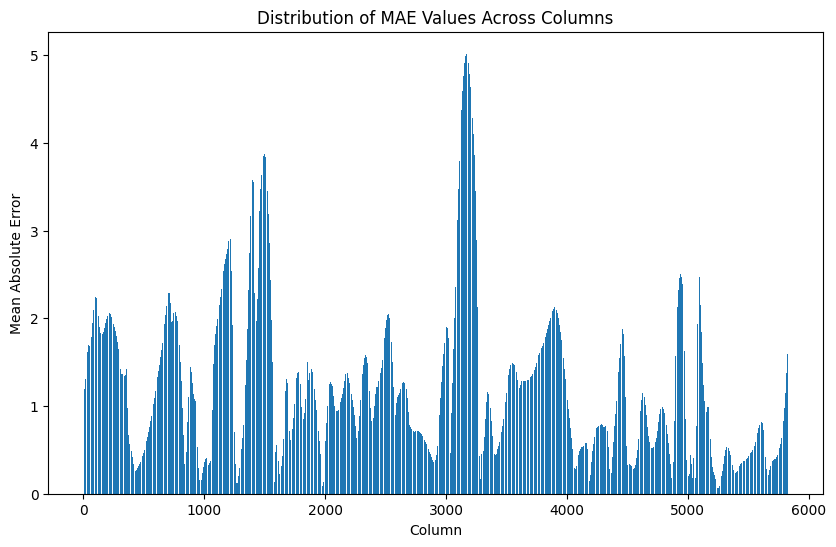

In [49]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [ ]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[0.6373618841171265,
 0.6373618841171265,
 0.7248349785804749,
 3.0604519844055176,
 -169.4912567138672]

**SSA**

**S2**

In [65]:

df_vwc2ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/s2vwc.csv', header = 0)[['TrendT', 'signal.detrend', 'Noise']].T.to_numpy()
df_stemp2ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/S2T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()

df_vwc7ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/s7vwc.csv', header = 0)[['Trend', 'signal.detrend', 'Noise']].T.to_numpy()
df_stemp7ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/S7T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()

df_vwc11ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/s11vwc.csv', header = 0)[['Trend', 'signal.detrend', 'Noise']].T.to_numpy()
df_stemp11ssa = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/S11T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()

df_T = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/T.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
df_RH = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/RH.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/R.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
df_WS = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/WS.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = pd.read_csv('/content/drive/Shareddrives/1st Paper/SSA/SR.csv', header = 0)[['trend_total', 'signal.detrend', 'noise_Stage2']].T.to_numpy()




In [66]:
pd.DataFrame(df_vwc2ssa)

,0,1,2,3,4,5,6,7,8,9,...,24181,24182,24183,24184,24185,24186,24187,24188,24189,24190
0,2.689037,2.741313,2.718699,2.446103,2.440195,2.417649,2.261846,2.272770,2.217083,2.211424,...,-0.292236,-0.537839,-0.100160,-0.479133,-0.074775,-0.503740,-0.399388,-0.495002,-0.040579,-0.652839
1,2.842761,2.797087,2.826129,3.105093,3.117349,3.146191,3.308173,3.303341,3.365029,3.376643,...,2.892826,3.135778,2.695528,3.071897,2.664945,3.091279,2.984331,3.077298,2.620203,3.229731
2,6.243202,6.294930,6.271842,5.998803,5.992456,5.969490,5.813311,5.823889,5.767888,5.761933,...,4.199410,3.952061,4.387965,4.007236,4.409830,3.979127,4.081724,3.984370,4.437042,3.823108


IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


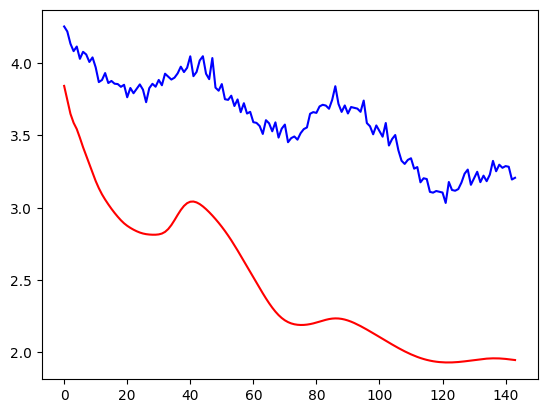

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


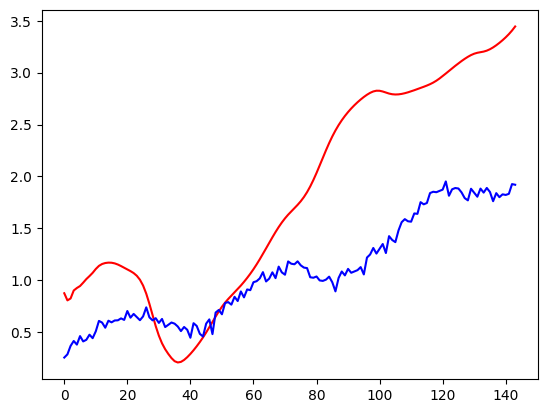

IMF:  2
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


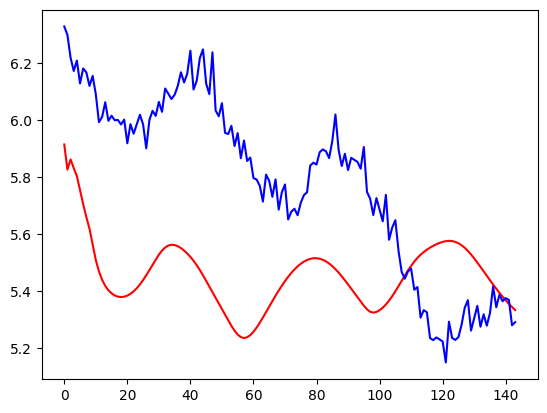

In [67]:



#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])



list_ = [df_vwc2ssa, df_Rain, df_stemp2ssa, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
ssa = [[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(ssa)):
  for i in list_:
    ssa[k].append(i[k])

FPssa2 = []
FP_tssa2 = []
FPassa2 = []
FP_tassa2 = []
for m in range(0, 3):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S2_best_model_ssa_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(ssa[m]).T
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S2_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S2_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df


  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPssa2.append(y_hat[v])
  FP_tssa2.append(test_y[v])

  FPassa2.append(p[0])
  FP_tassa2.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

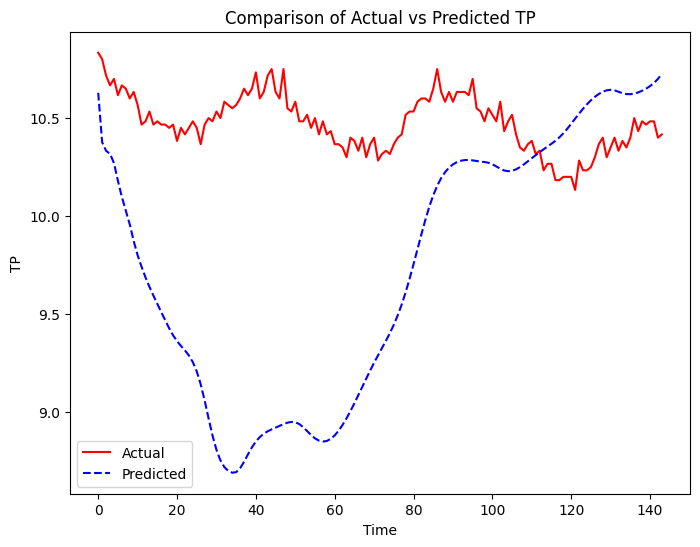

In [68]:
TP = sum(FPassa2[i] for i in range(3))
TP_t = sum(FP_tassa2[i] for i in range(3))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [69]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 0.82779735 mse 1.0423917 rmse 1.0209758 nmse 51.63158 smape 8.37603360414505 mape 0.07882037 r2 tf.Tensor(-50.631577, shape=(), dtype=float32)
mae 1.0825067 mse 2.2644827 rmse 1.5048199 nmse 1.6075518 smape 20.49587070941925 mape 0.2403605 r2 tf.Tensor(-0.60755134, shape=(), dtype=float32)


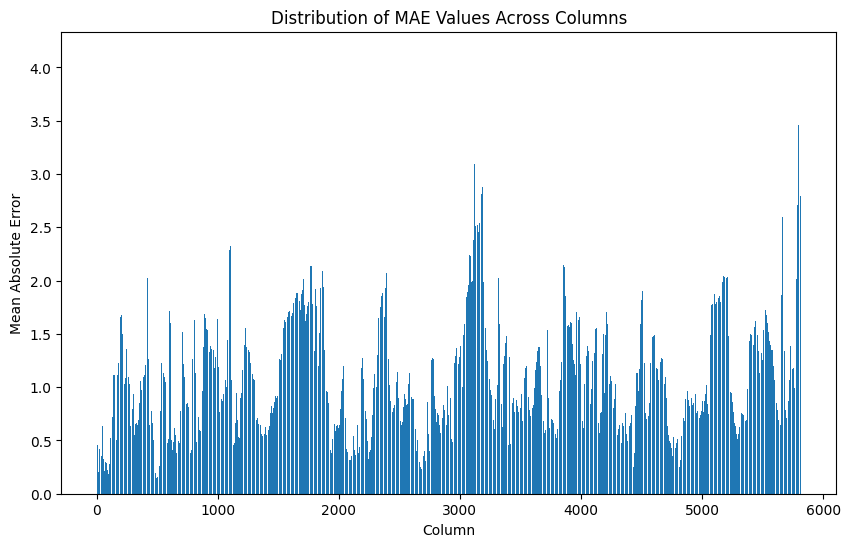

In [70]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()


In [60]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[1.082506775856018,
 1.082506775856018,
 2.2644827365875244,
 24.036043167114258,
 -11.383308410644531]

**S7**

IMF:  0
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
test_x shape (5791, 114, 7)
test_y shape (5791, 144)


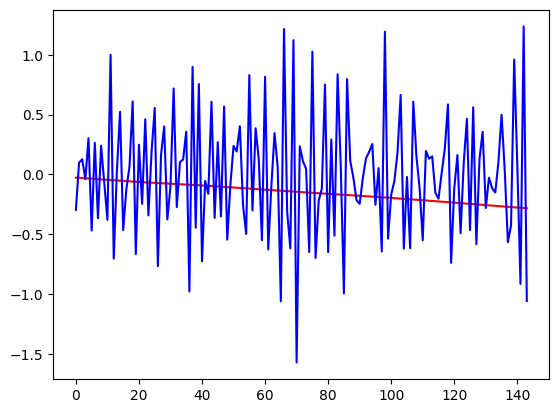

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
test_x shape (5822, 83, 7)
test_y shape (5822, 144)


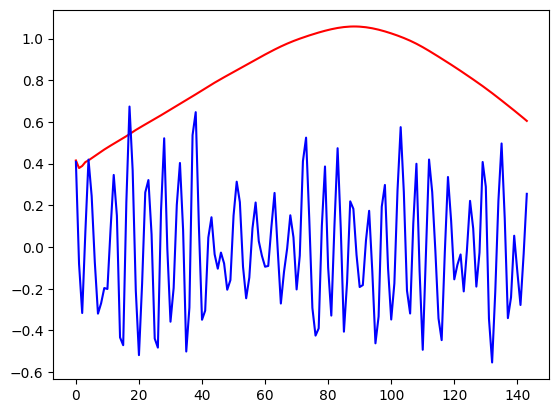

IMF:  2
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
test_x shape (5834, 71, 7)
test_y shape (5834, 144)


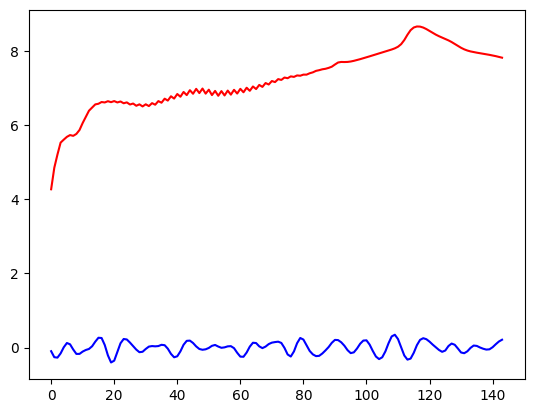

In [71]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])



list_ = [df_vwc7, df_Rain, df_stemp7, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
ssa = [[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(ssa)):
  for i in list_:
    ssa[k].append(i[k])

FPssa7 = []
FP_tssa7 = []

FPassa7 = []
FP_tassa7 = []

for m in range(0, 3):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S7_best_model_ssa_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(ssa[m]).T
  data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S7_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S7_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df


  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)
  print('test_x shape', test_X.shape)
  print('test_y shape', test_y.shape)
  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPssa7.append(y_hat[v])
  FP_tssa7.append(test_y[v])

  FPassa7.append(p[0])
  FP_tassa7.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

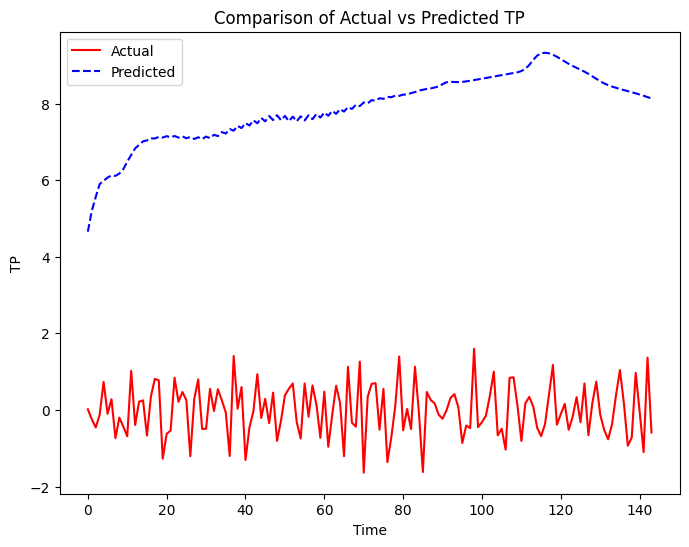

In [72]:
TP = sum(FPassa7[i] for i in range(3))
TP_t = sum(FP_tassa7[i] for i in range(3))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [73]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 7.9042544 mse 63.697624 rmse 7.981079 nmse 142.2136 smape 187.5668168067932 mape 38.809555 r2 tf.Tensor(-141.21358, shape=(), dtype=float32)
mae 7.9823837 mse 69.88862 rmse 8.3599415 nmse 1475.0254 smape 196.0718870162964 mape 285.81104 r2 tf.Tensor(-1474.0258, shape=(), dtype=float32)


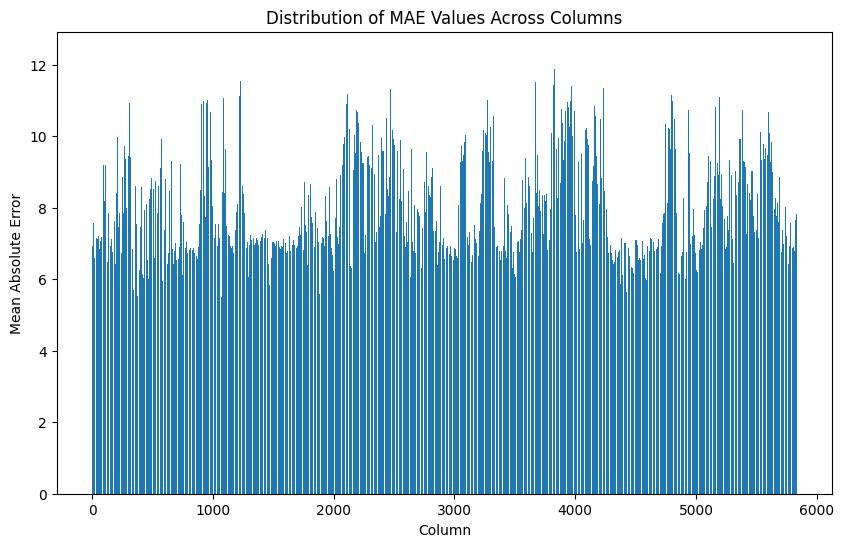

In [74]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [65]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[7.982385635375977,
 7.982385635375977,
 69.88861846923828,
 28581.107421875,
 -2234.66455078125]

**S11**

IMF:  0
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


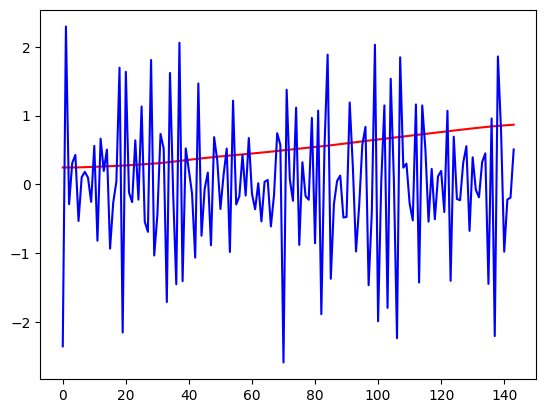

IMF:  1
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


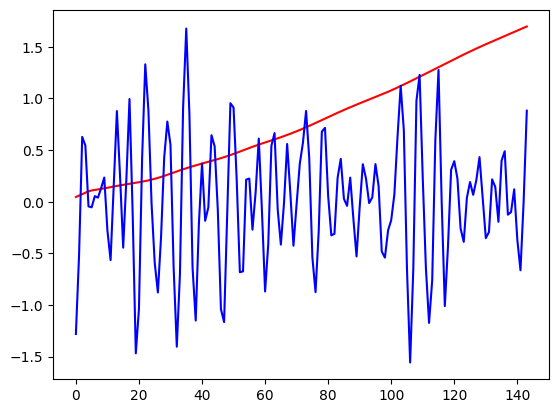

IMF:  2
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


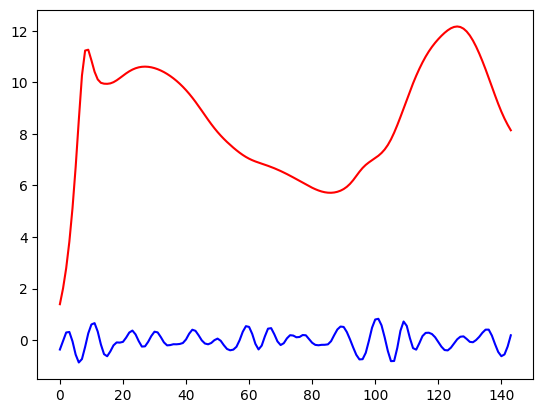

In [61]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])



list_ = [df_vwc11, df_Rain, df_stemp11, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
ssa = [[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(ssa)):
  for i in list_:
    ssa[k].append(i[k])

FPssa11 = []
FP_tssa11 = []

FPassa11 = []
FP_tassa11 = []

for m in range(0, 3):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S11_best_model_ssa_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)

  print('IMF: ', m)
  data = pd.DataFrame(ssa[m]).T
  data.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S11_Top_VWC_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S11_Top_VWC_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df


  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPssa11.append(y_hat[v])
  FP_tssa11.append(test_y[v])

  FPassa11.append(p[0])
  FP_tassa11.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

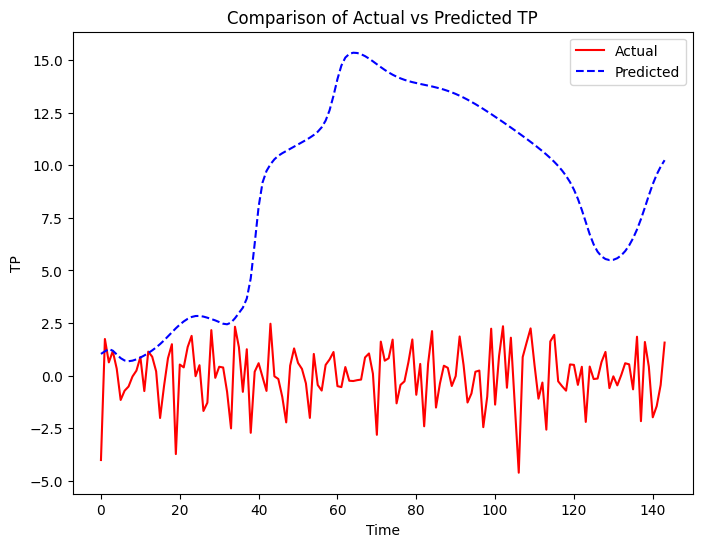

In [62]:
TP = sum(FPassa11[i] for i in range(3))
TP_t = sum(FP_tassa11[i] for i in range(3))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [63]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 8.714295 mse 100.10907 rmse 10.005452 nmse 56.844444 smape 168.74014139175415 mape 27.616533 r2 tf.Tensor(-55.844444, shape=(), dtype=float32)
mae 7.4350715 mse 96.7227 rmse 9.83477 nmse 64.241104 smape 177.07566022872925 mape 99.54378 r2 tf.Tensor(-63.241135, shape=(), dtype=float32)


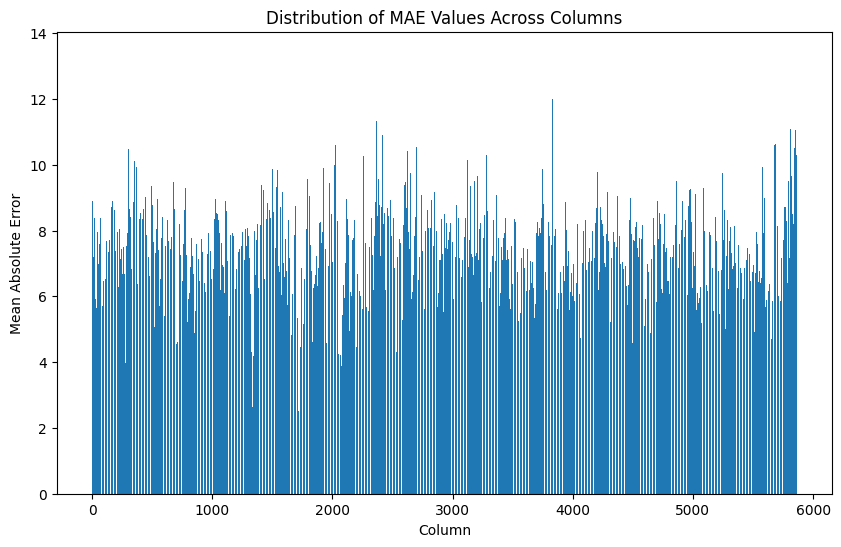

In [64]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [ ]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[8.639365196228027,
 8.639365196228027,
 115.52254486083984,
 321801.8125,
 -11986.486328125]

**Standalone**

**s2**

IMF:  0
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
Scale_: [1.84464099e-02 5.33751677e+00 5.82719756e+00 1.78601517e+01
 3.17586211e+00 2.53279840e+02]


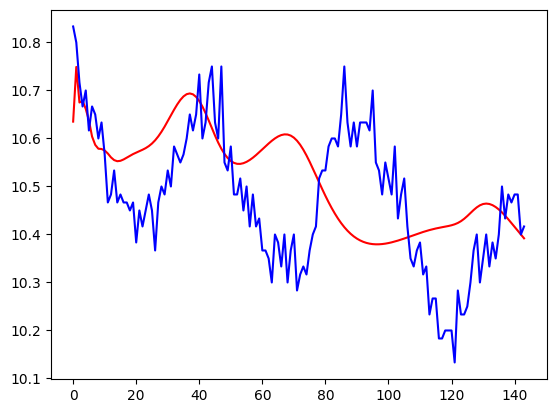

In [75]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

dfm = dataset[['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]


FPst2 = []
FP_tst2 = []

FPast2 = []
FP_tast2 = []

for m in range(0, 1):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S2_best_model_Alone_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)


  print('IMF: ', m)
  data = dfm
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']
  #testing = data[-8438:]
  #data = data[:-8438]
  data = data

  %time
  External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S2_Top_VWC_Avg']].reset_index()
  index = pd.DataFrame(dataset.index)

  scaler = StandardScaler()
  scaler.fit(External)
  print('Scale_:', scaler.scale_)

  var = pd.DataFrame(scaler.transform(External))

  #var = data
  df = pd.concat([Predicted, var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPst2.append(y_hat[v])
  FP_tst2.append(test_y[v])

  FPast2.append(p[0])
  FP_tast2.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

In [76]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[1.4980700016021729,
 1.4980700016021729,
 4.937266826629639,
 21.0107479095459,
 -27.473703384399414]

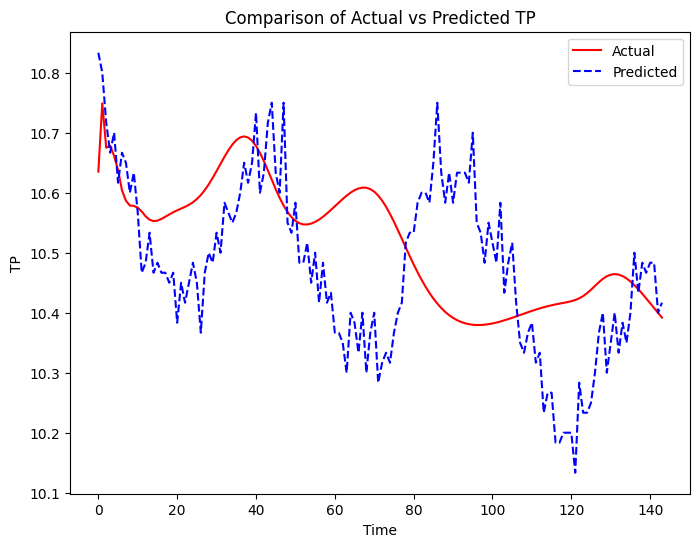

In [77]:
TP = sum(FPast2[i] for i in range(1))
TP_t = sum(FP_tast2[i] for i in range(1))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP, color='red', label='Actual')
ax.plot(TP_t, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [78]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 0.12637003 mse 0.022487044 rmse 0.14995681 nmse 1.1138248 smape 1.206191722303629 mape 0.012097456 r2 tf.Tensor(-0.113824844, shape=(), dtype=float32)
mae 1.4980702 mse 4.9372663 rmse 2.221996 nmse 1.8769314 smape 17.667174339294434 mape 0.21010746 r2 tf.Tensor(-0.8769306, shape=(), dtype=float32)


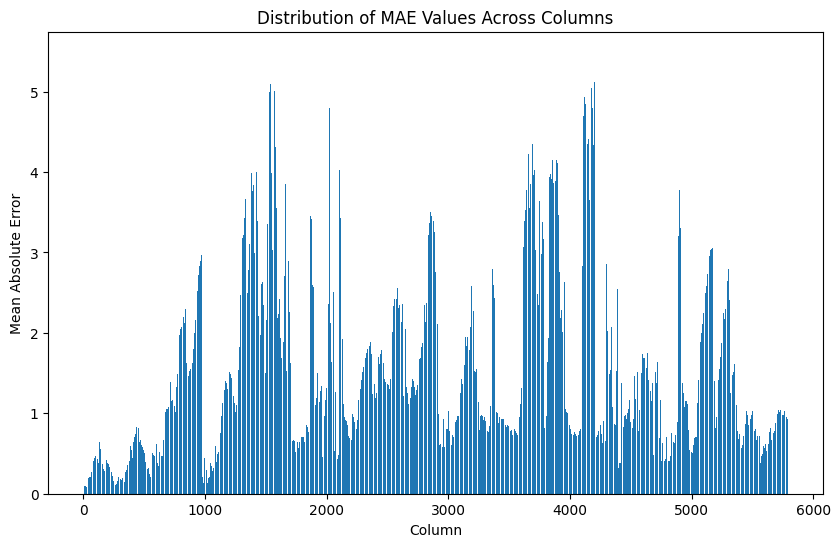

In [79]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

**s7**

IMF:  0
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Scale_: [1.84464099e-02 4.54171343e+00 5.82719756e+00 1.78601517e+01
 3.17586211e+00 2.53279840e+02]


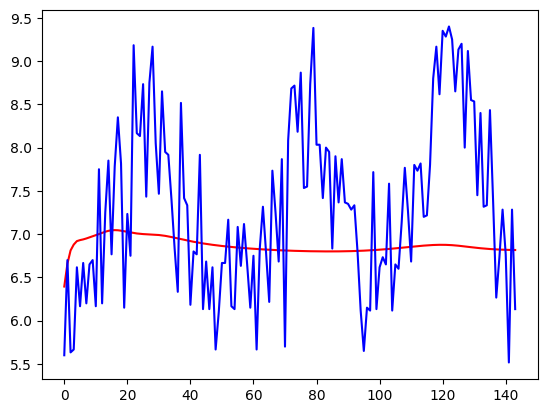

In [80]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time']).reset_index()
s7 = pd.read_csv('/content/drive/Shareddrives/1st Paper/s7.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()

dfm = pd.concat([dataset, s7], axis = 1).set_index('Date Time')
dfm = dfm[['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
FPst7 = []
FP_tst7 = []

FPast7 = []
FP_tast7 = []

for m in range(0, 1):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S7_best_model_Alone_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)


  print('IMF: ', m)
  data = dfm
  data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']
  #testing = data[-8438:]
  #data = data[:-8438]
  data = data

  %time
  External = data[['Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S7_Top_VWC_Avg']].reset_index()
  index = pd.DataFrame(dataset.index)

  scaler = StandardScaler()
  scaler.fit(External)
  print('Scale_:', scaler.scale_)

  var = pd.DataFrame(scaler.transform(External))

  #var = data
  df = pd.concat([Predicted, var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPst7.append(y_hat[v])
  FP_tst7.append(test_y[v])

  FPast7.append(p[0])
  FP_tast7.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

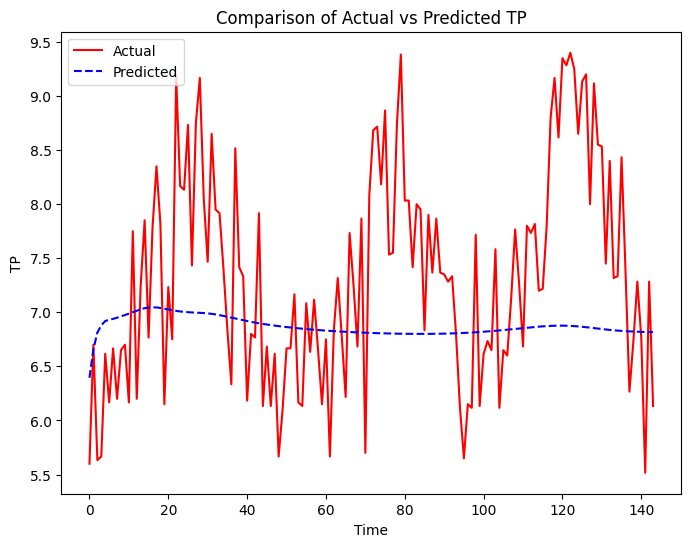

In [81]:
TP = sum(FPast7[i] for i in range(1))
TP_t = sum(FP_tast7[i] for i in range(1))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [82]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 0.8662423 mse 1.1709999 rmse 1.0821275 nmse 1.1991773 smape 11.834070086479187 mape 0.112845525 r2 tf.Tensor(-0.19917738, shape=(), dtype=float32)
mae 1.1155341 mse 3.2236922 rmse 1.7954643 nmse 2.0331519 smape 13.25879842042923 mape 0.13963258 r2 tf.Tensor(-1.0331514, shape=(), dtype=float32)


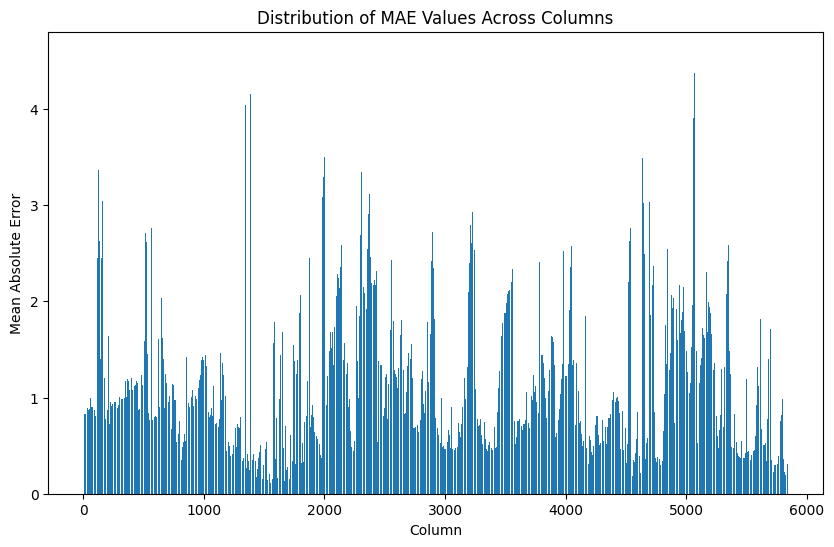

In [83]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [ ]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[1.1155340671539307,
 1.1155340671539307,
 3.223693370819092,
 13.963257789611816,
 -29.223936080932617]

**S11**

IMF:  0
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
Scale_: [1.84464099e-02 4.70657264e+00 5.82719756e+00 1.78601517e+01
 3.17586211e+00 2.53279840e+02]


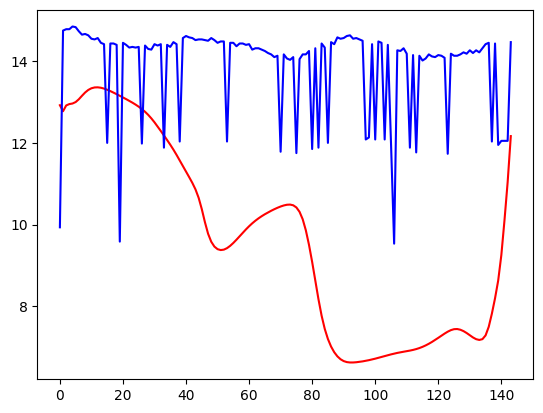

In [84]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time']).reset_index()
s11 = pd.read_csv('/content/drive/Shareddrives/1st Paper/s11.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()

dfm = pd.concat([dataset, s11], axis = 1).set_index('Date Time')
dfm = dfm[['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
FPst11 = []
FP_tst11 = []

FPast11 = []
FP_tast11 = []

for m in range(0, 1):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S11_best_model_Alone_VWC'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)


  print('IMF: ', m)
  data = dfm
  data.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']
  #testing = data[-8438:]
  #data = data[:-8438]
  data = data

  %time
  External = data[['Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S11_Top_VWC_Avg']].reset_index()
  index = pd.DataFrame(dataset.index)

  scaler = StandardScaler()
  scaler.fit(External)
  print('Scale_:', scaler.scale_)

  var = pd.DataFrame(scaler.transform(External))

  #var = data
  df = pd.concat([Predicted, var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  v=0
  a, b = to_supervised(test, n_input =100)
  p = loaded_model.predict(a, verbose = 0)
  p = p.reshape(p.shape[0], p.shape[1])

  FPst11.append(y_hat[v])
  FP_tst11.append(test_y[v])

  FPast11.append(p[0])
  FP_tast11.append(b[0])

  plt.plot(p[0], color = 'red')
  plt.plot(b[0], color = 'blue')
  plt.show();

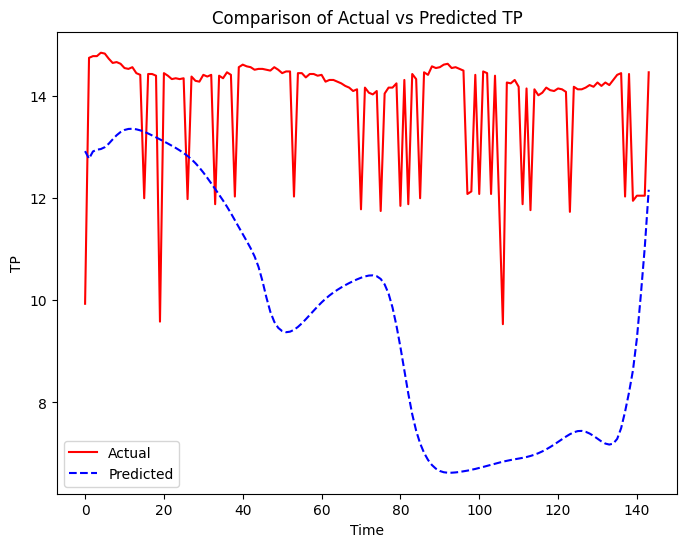

In [85]:
TP = sum(FPast11[i] for i in range(1))
TP_t = sum(FP_tast11[i] for i in range(1))

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(TP_t, color='red', label='Actual')
ax.plot(TP, color='blue', linestyle='--', label='Predicted')

# Add axis labels and a title
ax.set_xlabel('Time')
ax.set_ylabel('TP')
ax.set_title('Comparison of Actual vs Predicted TP')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [86]:
actual= TP_t
predicted= TP

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)


actual= test_y
predicted= y_hat.reshape(y_hat.shape[0], 144)

actual = np.array(actual).astype('float32')
predicted = np.array(predicted).astype('float32')

mae_score = mean_absolute_error(actual, predicted)
mse_score = mean_squared_error(actual, predicted)
mape_score = mean_absolute_percentage_error(actual, predicted)
rmse_score = rmse_(actual, predicted)
nmse_score = nmse(actual, predicted)
smape_score = smape(actual, predicted)
r2_score = r2_keras(actual, predicted)
print('mae',mae_score,'mse', mse_score, 'rmse', rmse_score, 'nmse', nmse_score, 'smape',  smape_score,'mape', mape_score, 'r2', r2_score)

mae 4.377606 mse 24.463116 rmse 4.94602 nmse 20.533998 smape 39.28346037864685 mape 0.3142822 r2 tf.Tensor(-19.533998, shape=(), dtype=float32)
mae 4.6530476 mse 51.587772 rmse 7.1824627 nmse 1.1982002 smape 65.6646192073822 mape 3089751200000000.0 r2 tf.Tensor(-0.1982001, shape=(), dtype=float32)


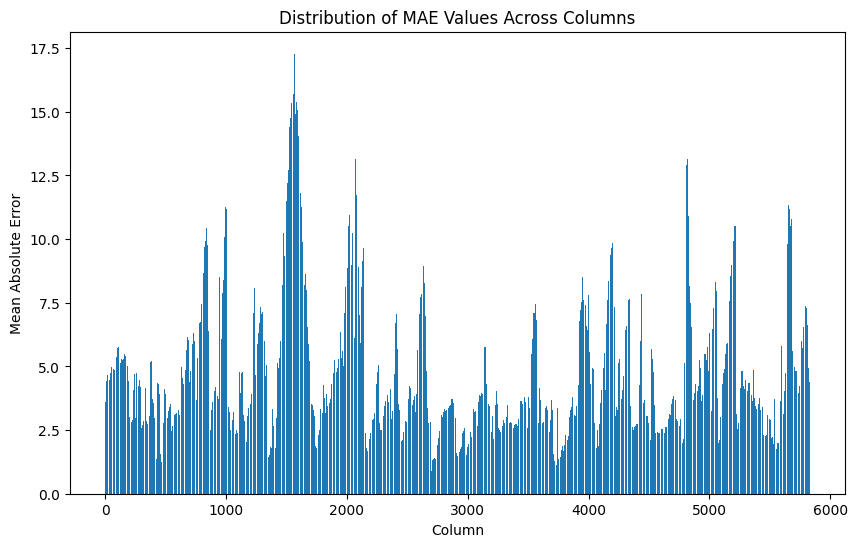

In [87]:
actual = pd.DataFrame(actual).T
predited = pd.DataFrame(predicted).T
mae_scores = []
columns = actual.columns

for col in columns:
    mae = mean_absolute_error(actual[col], predicted[col])
    mae_scores.append(mae)



plt.figure(figsize=(10, 6))
plt.bar(columns, mae_scores)
plt.xlabel('Column')
plt.ylabel('Mean Absolute Error')
plt.title('Distribution of MAE Values Across Columns')
plt.show()

In [ ]:
y_hss = loaded_model.evaluate(test_X, test_y, verbose=0)
y_hss

[4.653048038482666,
 4.653048038482666,
 51.587806701660156,
 686062464.0,
 -4.506031513214111]

**Training metrics**

In [6]:
import pandas as pd
Tr_p = pd.read_csv('/content/drive/Shareddrives/1st Paper/Performance/Training Metrics.csv', header = 0)
Tr_p.columns = ['Component', 'MAE-LSTM-ED', 'RMSE-LSTM-ED', 'MAPE-LSTM-ED', 'R2-LSTM-ED', 'MAE-RF', 'MSE-RF', 'MAPE-RF',
       'R2-RF', 'Processing', 'Sensor']

In [7]:
Tr_p = Tr_p.replace('Raw TS', 'Original TS')
Tr_p = Tr_p.replace('ST', 'Standalone')


In [34]:
Tr_p = Tr_p.replace('Nonstructural', 'NS.')
Tr_p = Tr_p.replace('Standalone', 'Original')
Tr_p

,Component,MAE-LSTM-ED,RMSE-LSTM-ED,MAPE-LSTM-ED,R2-LSTM-ED,MAE-RF,MSE-RF,MAPE-RF,R2-RF,Processing,Sensor
0,1,0.1566,0.059000,1.946000e+02,0.0045,0.1590,0.24000,27080.1000,0.0259,EEMD,1
1,2,0.1006,0.033900,1.227000e+02,0.0447,0.1004,0.18050,26543.5000,0.0767,EEMD,1
2,3,0.0909,0.040700,1.541000e+02,0.0856,0.0917,0.01981,25663.0000,0.1144,EEMD,1
3,4,0.0809,0.043200,1.978000e+02,0.4358,0.0982,0.23700,24274.9000,0.2441,EEMD,1
4,5,0.0425,0.012100,2.219000e+02,0.9153,0.1227,0.26390,19899.5000,0.4839,EEMD,1
5,6,0.0430,0.008300,1.702000e+02,0.9537,0.1279,0.24170,16799.2000,0.6937,EEMD,1
6,7,0.0230,0.002600,8.460000e+01,0.9914,0.0613,0.10590,12028.5600,0.9598,EEMD,1
7,8,0.0138,0.000695,4.940000e+01,0.9978,0.0236,0.03590,4969.9000,0.9956,EEMD,1
8,9,0.0396,0.003100,4.000000e-01,0.9991,0.2250,0.33230,330.3000,0.9651,EEMD,1
9,1,0.5431,2.727500,1.451000e+02,0.0331,0.5390,1.65670,27867.7000,0.0221,EEMD,2


In [9]:
Tr_p[(Tr_p['Component']=='1')]['MAE-LSTM-ED']

0     0.1566
9     0.5431
18    0.0786
Name: MAE-LSTM-ED, dtype: float64

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu

f_val, p_val = f_oneway(Tr_p[(Tr_p['Component']=='1')]['MAPE-LSTM-ED'], Tr_p[(Tr_p['Component']=='1')]['MAPE-RF'])
p_val

2.910356532770969e-08

<Axes: xlabel='R2-LSTM-ED', ylabel='MAE-LSTM-ED'>

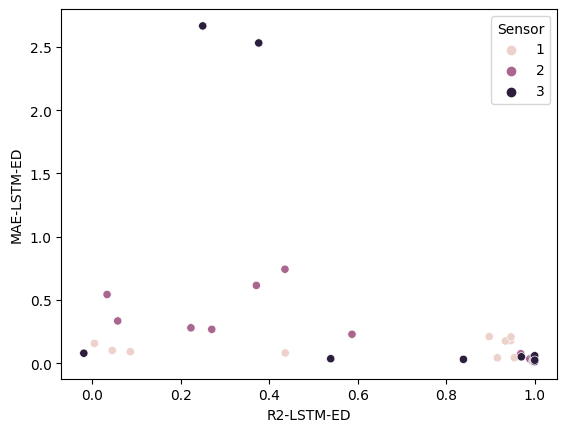

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=Tr_p['R2-LSTM-ED'],y=Tr_p['MAE-LSTM-ED'], hue=Tr_p['Sensor'] )


<Axes: xlabel='R2-RF', ylabel='MAE-RF'>

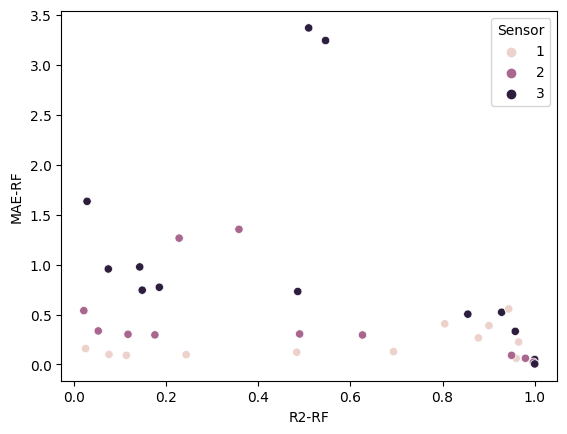

In [ ]:
sns.scatterplot(x=Tr_p['R2-RF'],y=Tr_p['MAE-RF'], hue=Tr_p['Sensor'] )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

L = ['MAE-LSTM-ED', 'RMSE-LSTM-ED', 'MAPE-LSTM-ED', 'R2-LSTM-ED', 'MAE-RF', 'MSE-RF', 'MAPE-RF', 'R2-RF']

# Assuming the sensor column has three unique values 'Sensor1', 'Sensor2', 'Sensor3'
marker_dict = {1: 'o', 2: 'v', 3: 's'}

for i in L:
    plt.figure(figsize=(8, 8))

    for sensor, marker in marker_dict.items():
        mask = Tr_p['Sensor'] == sensor
        sns.stripplot(x="Component", y=i, data=Tr_p[mask], marker=marker, color='black', dodge=False)

    sns.boxplot(x="Component", y=i, data=Tr_p, hue='Processing', dodge=False)

    plt.xlabel("Component")
    plt.ylabel(i)
    plt.title(i)

    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom color palette
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]  # Specify the colors you want to use

# Create the stripplot with the custom color palette
plt.figure(figsize=(10, 10))
strip = sns.stripplot(x="Component", y="MSE-RF", data=Tr_p, hue="Processing", palette=custom_palette, dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Component", loc="upper left")
legend2 = plt.legend(handles[3:], labels[3:], title="Processing", loc="upper right")
plt.gca().add_artist(legend1)

# Add labels
plt.xlabel("Component")
plt.ylabel("MSE-RF")
plt.title("MSE-RF")

# Display the plot
plt.show()

dtype('int64')

In [ ]:
Tr_p.columns = ['Component', 'MAE-LSTM-ED', 'RMSE-LSTM-ED', 'MAPE-LSTM-ED', 'R2-LSTM-ED', 'MAE-RF', 'MSE-RF', 'MAPE-RF',
       'R2-RF', 'Processing', 'Sensor']

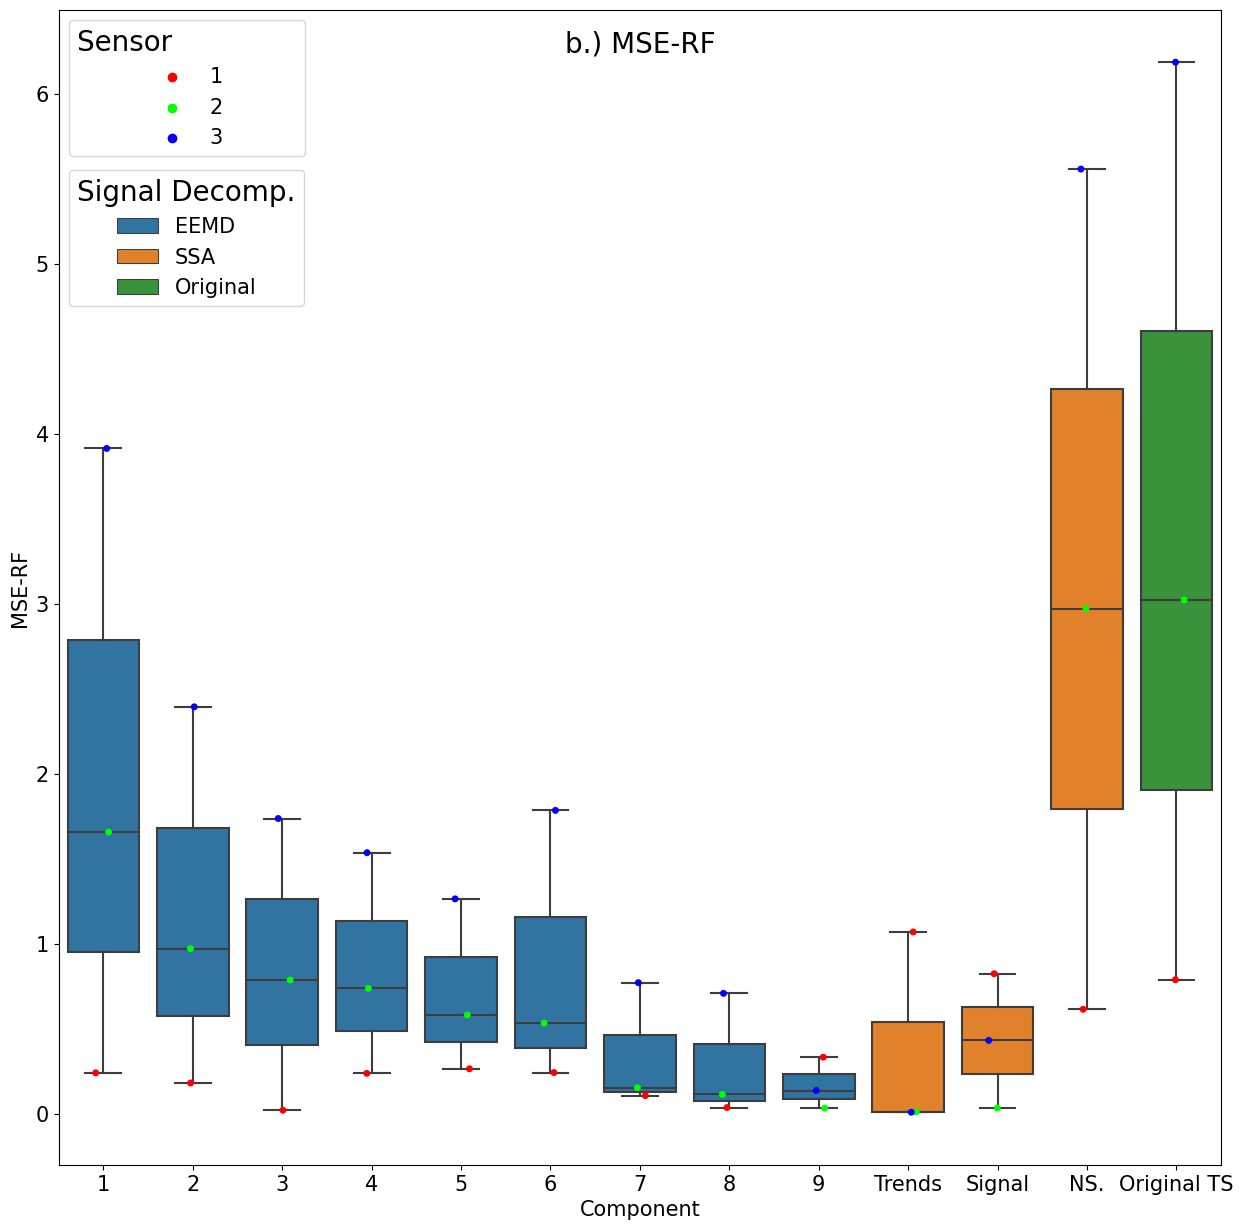

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="MSE-RF", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="MSE-RF", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("MSE-RF", fontsize=15)


# Add title inside the graph area (customize the coordinates as needed)
plt.text(0.5, 0.97, 'b.) MSE-RF', horizontalalignment='center', verticalalignment='center', transform=strip.transAxes, fontsize=20)


# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()


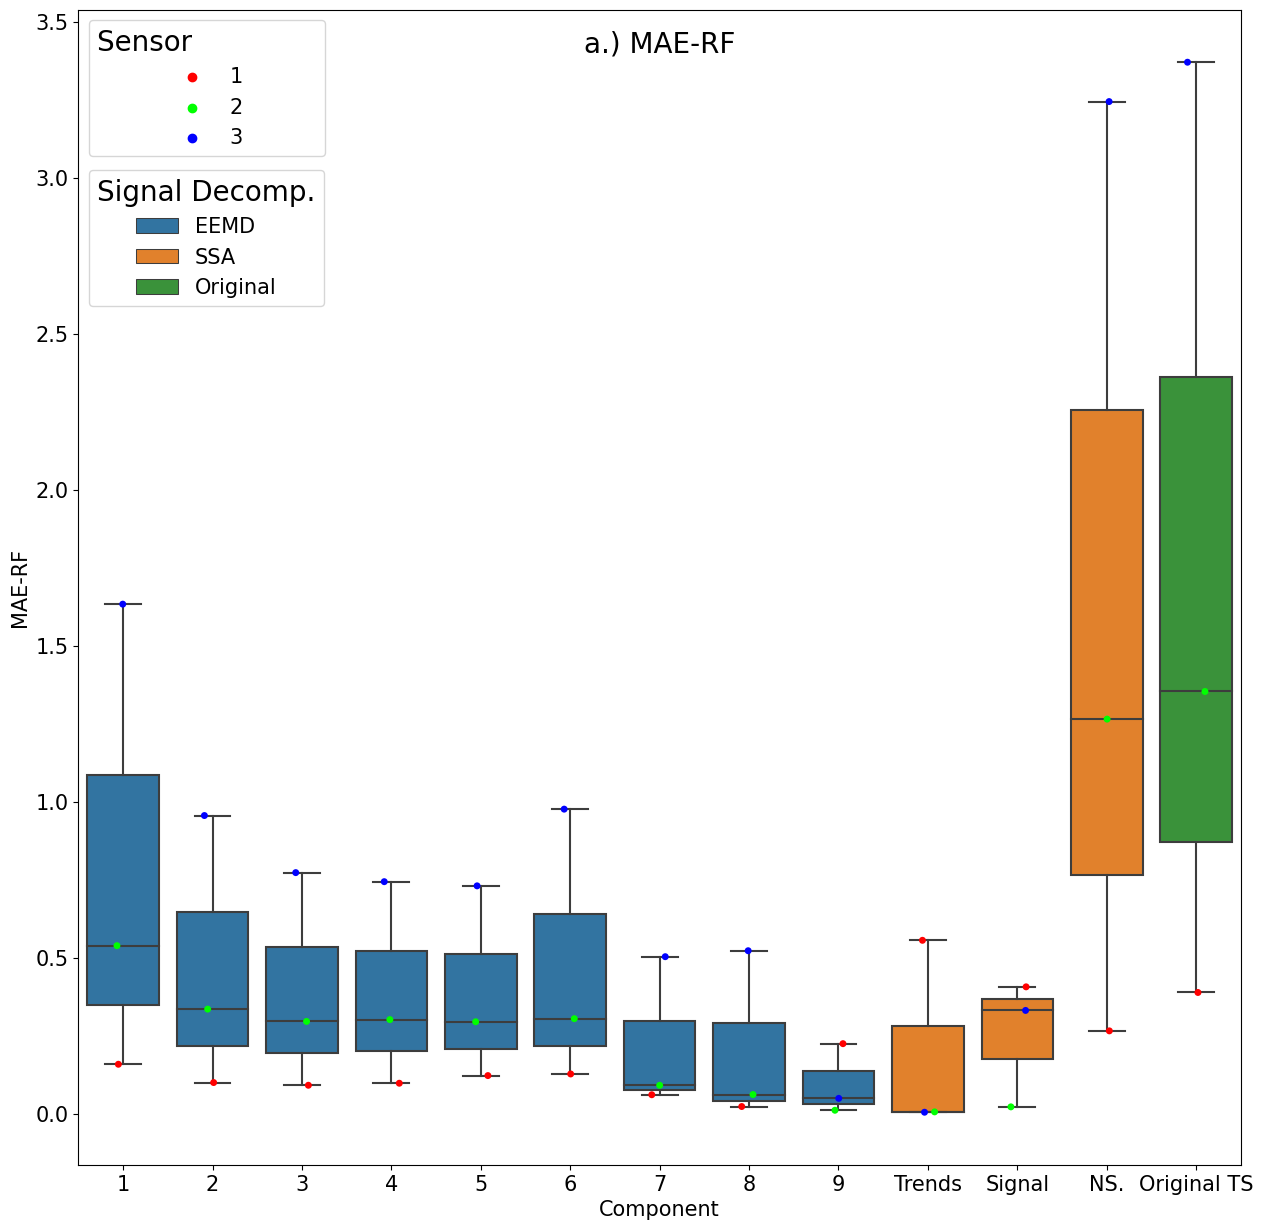

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="MAE-RF", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="MAE-RF", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("MAE-RF", fontsize=15)

# Add title inside the graph area (customize the coordinates as needed)
plt.text(0.5, 0.97, 'a.) MAE-RF', horizontalalignment='center', verticalalignment='center', transform=strip.transAxes, fontsize=20)

# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()


In [ ]:
Tr_p

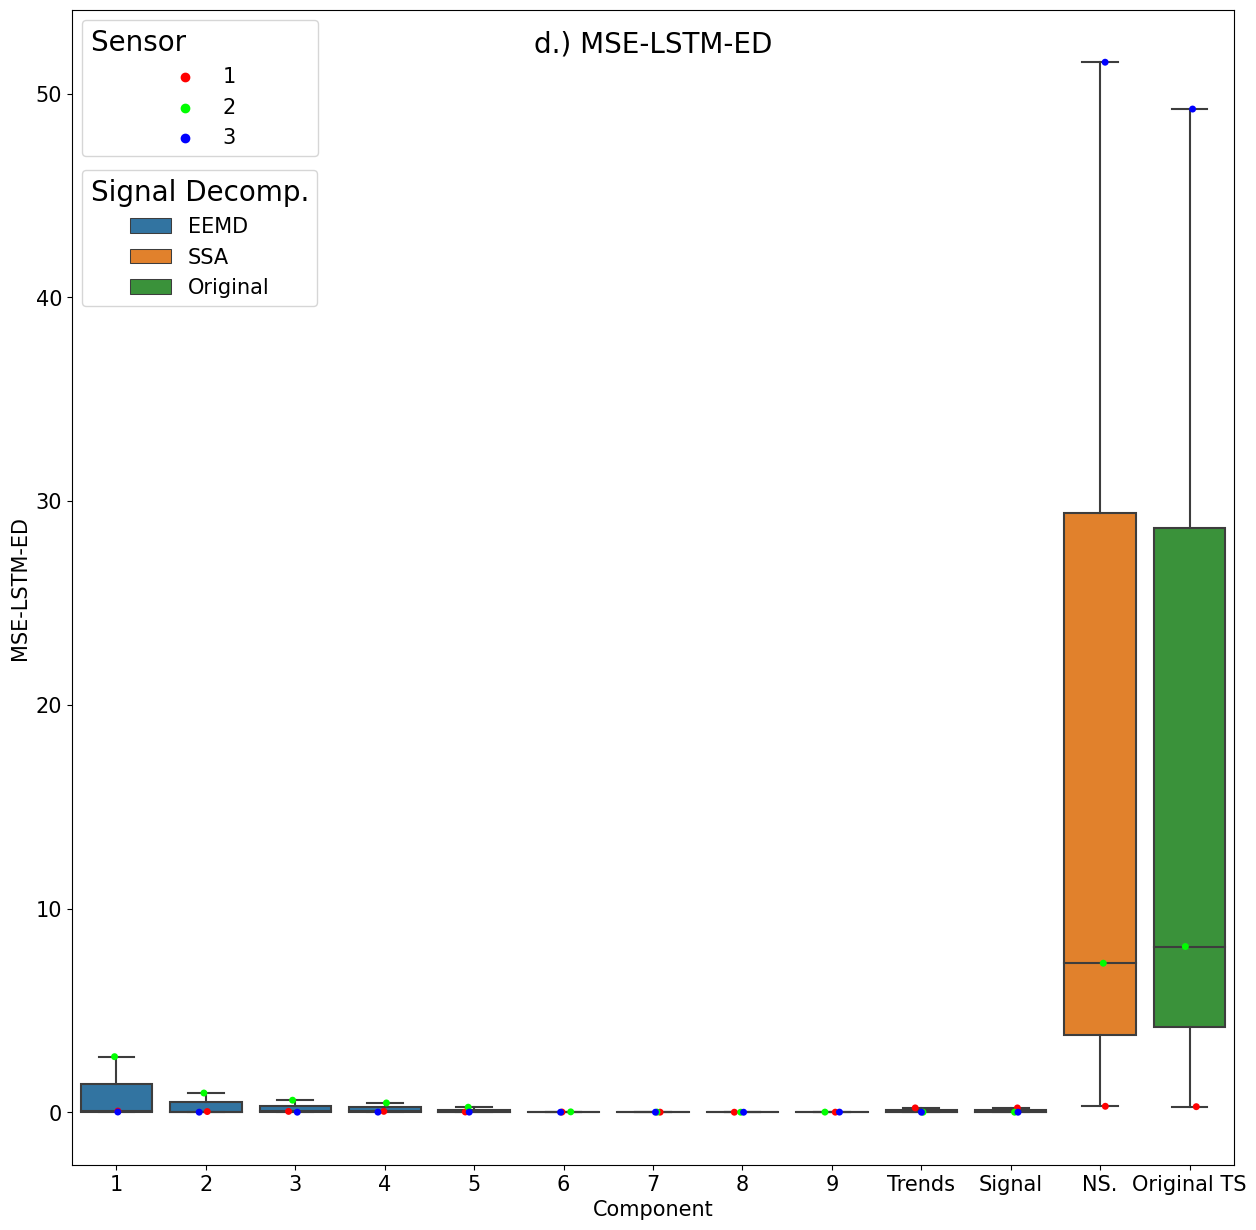

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="RMSE-LSTM-ED", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="RMSE-LSTM-ED", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("MSE-LSTM-ED", fontsize=15)

# Add title inside the graph area (customize the coordinates as needed)
plt.text(0.5, 0.97, 'd.) MSE-LSTM-ED', horizontalalignment='center', verticalalignment='center', transform=strip.transAxes, fontsize=20)


# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()


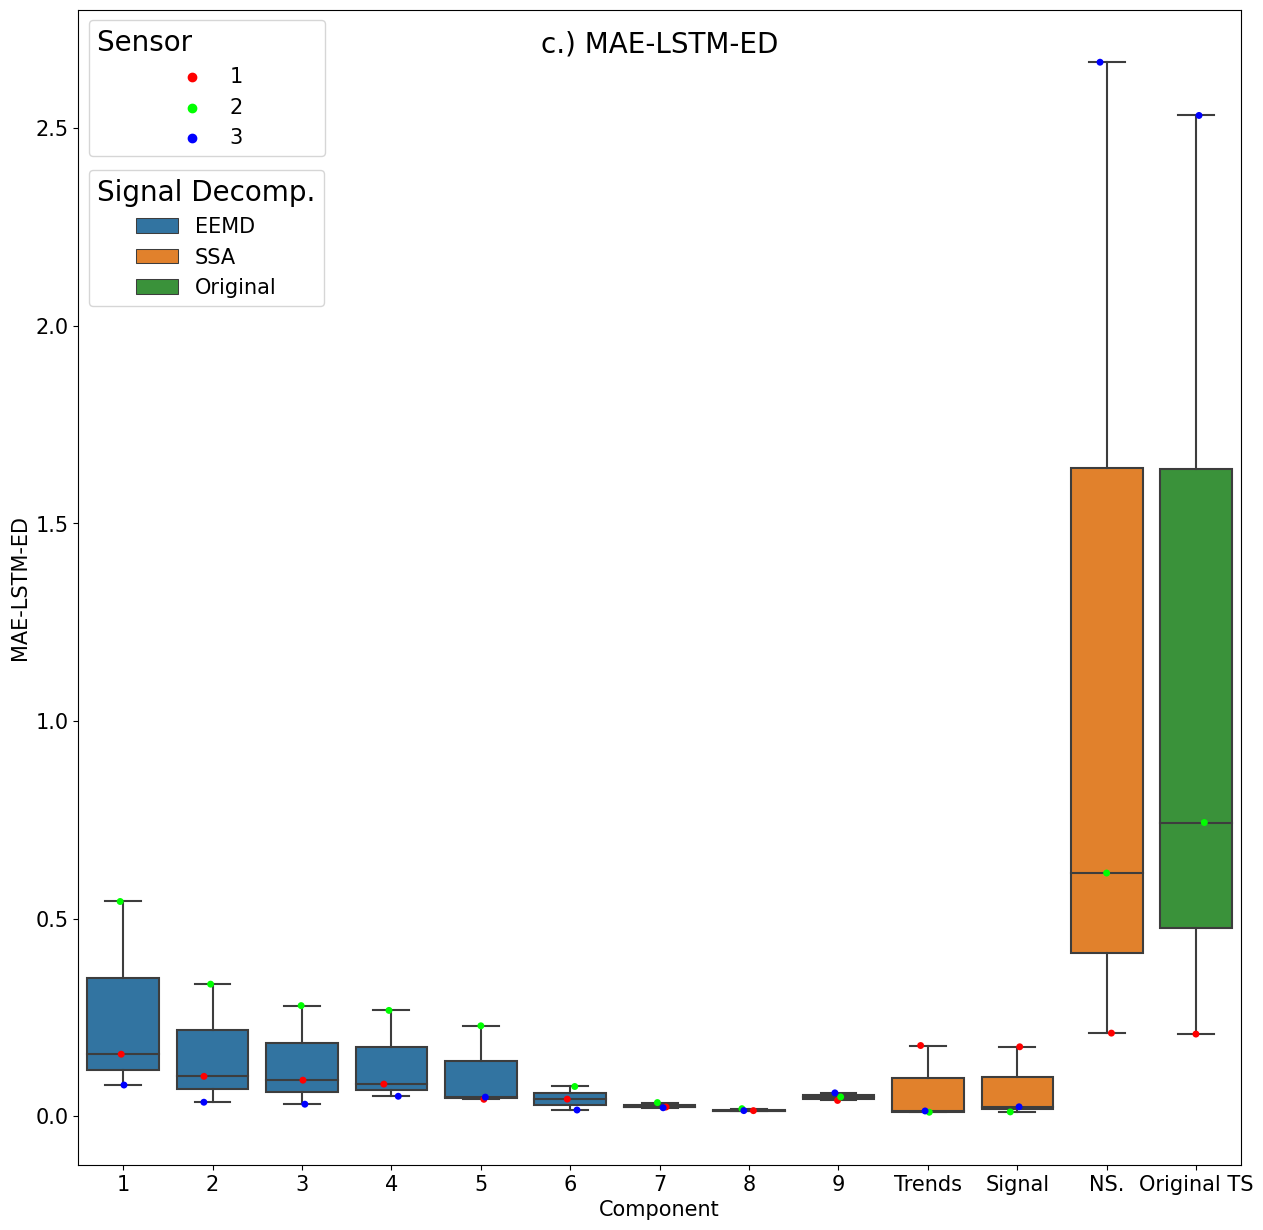

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="MAE-LSTM-ED", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="MAE-LSTM-ED", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("MAE-LSTM-ED", fontsize=15)

# Add title inside the graph area (customize the coordinates as needed)
plt.text(0.5, 0.97, 'c.) MAE-LSTM-ED', horizontalalignment='center', verticalalignment='center', transform=strip.transAxes, fontsize=20)


# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()


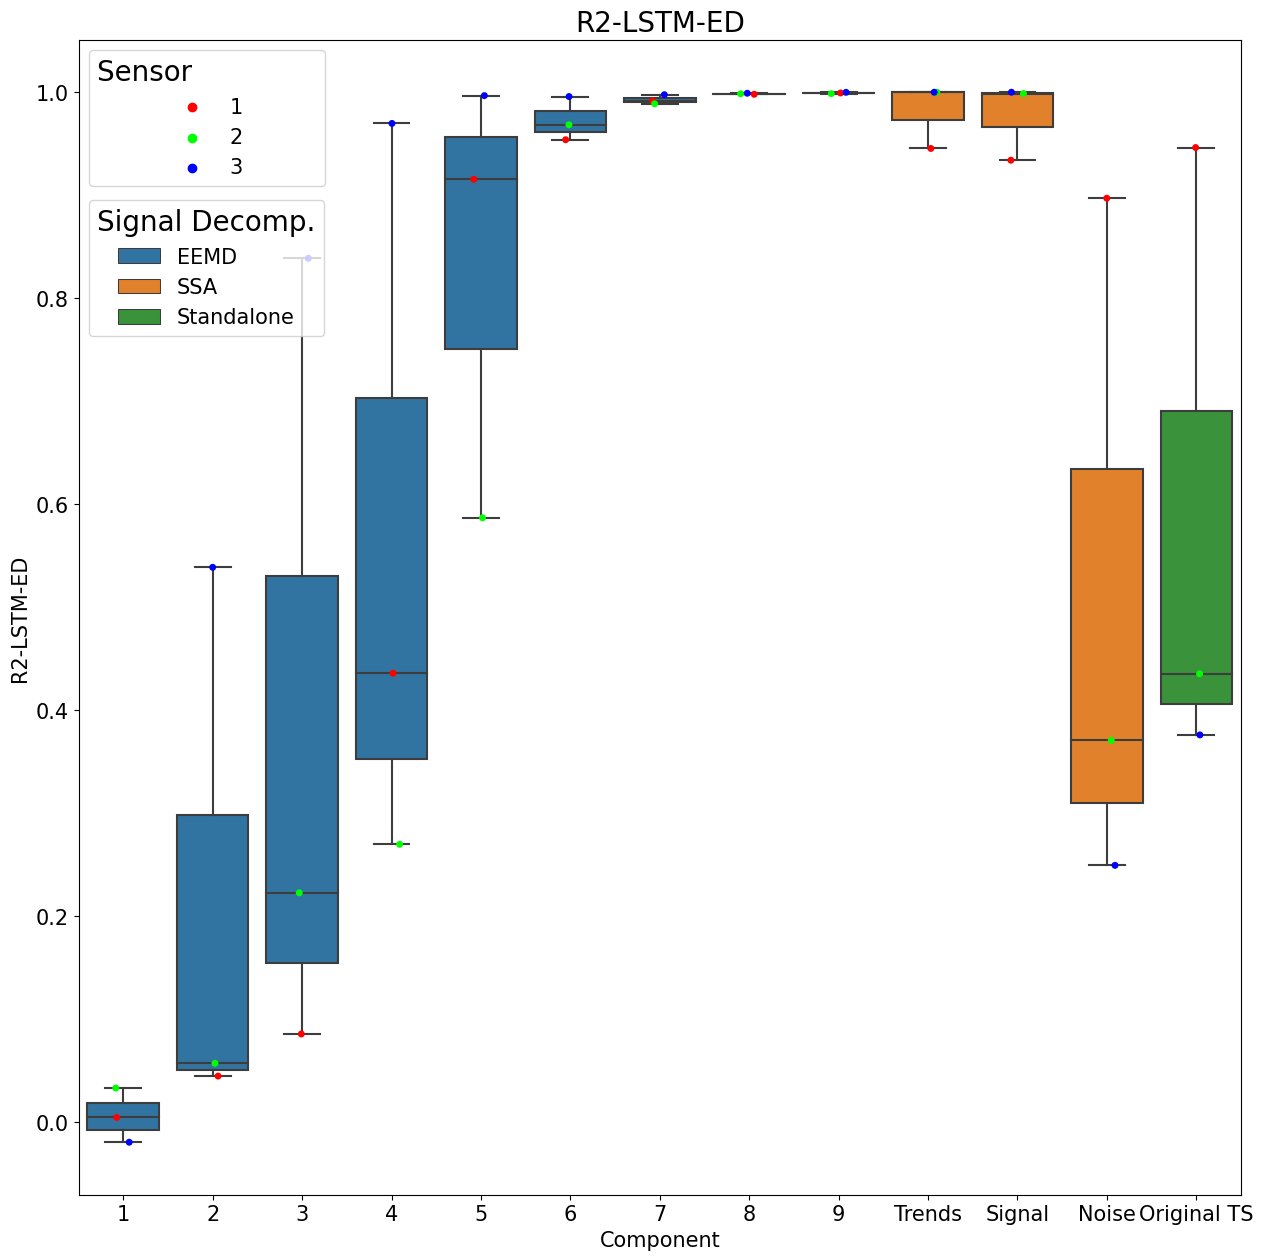

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="R2-LSTM-ED", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="R2-LSTM-ED", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("R2-LSTM-ED", fontsize=15)

# Increase the size of title
plt.title("R2-LSTM-ED", fontsize=20)

# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()

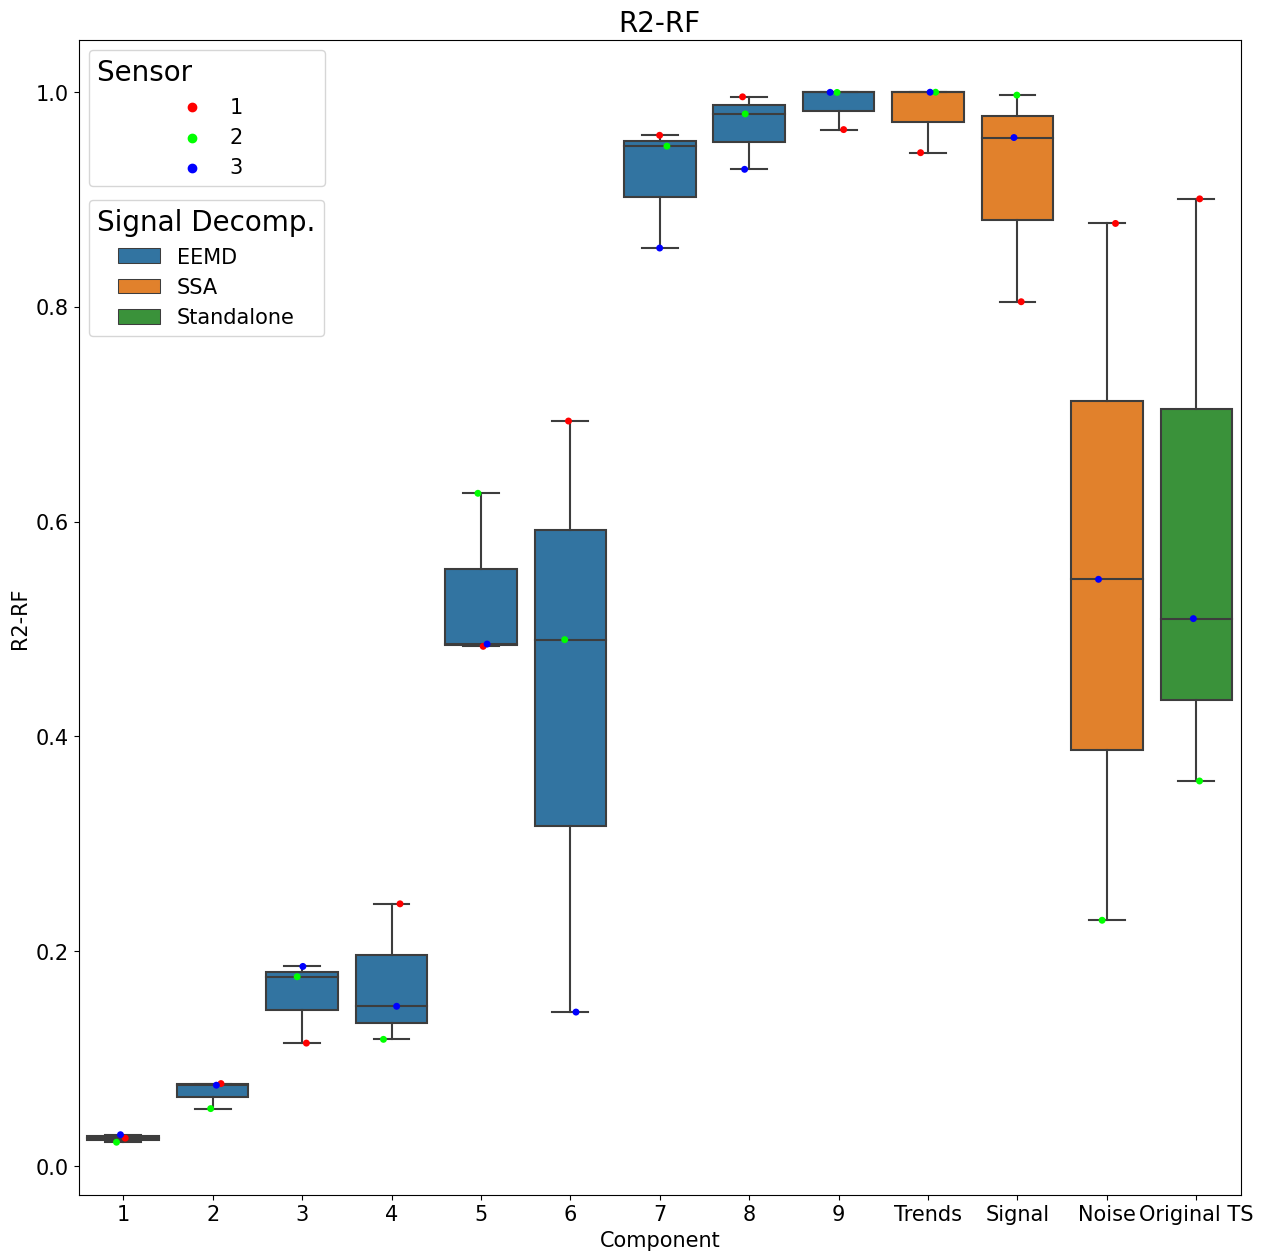

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# create violin plot
plt.figure(figsize=(15, 15))
custom_palette = ["#FF0000", "#00FF00", "#0000FF"]

strip = sns.stripplot(x="Component", y="R2-RF", data=Tr_p, hue="Sensor", palette=custom_palette,dodge=False)
sns.boxplot(x="Component", y="R2-RF", data=Tr_p, hue='Processing', dodge=False)

# Customize the legend
handles, labels = strip.get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], title="Sensor              ", loc="upper left", bbox_to_anchor=(0,1), prop={'size': 15}, title_fontsize='20')
legend2 = plt.legend(handles[3:], labels[3:], title="Signal Decomp.", loc="upper left", bbox_to_anchor=(0,0.87), prop={'size': 15}, title_fontsize='20')
plt.gca().add_artist(legend1)

# Increase the size of axis labels
plt.xlabel("Component", fontsize=15)
plt.ylabel("R2-RF", fontsize=15)

# Increase the size of title
plt.title("R2-RF", fontsize=20)

# Increase size of axis numbers (ticks)
plt.tick_params(axis='both', which='major', labelsize=15)

# display plot
plt.show()